In [1]:
import shap
print(shap.__version__)

/opt/miniconda3/envs/triage_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0.45.0


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
#import sweetviz as sv
import pandas as pd
#import dtale
#import numpy as np
#from sdmetrics.reports.multi_table import QualityReport
%matplotlib inline


import os
import json

#from pandas.io.json import json_normalize
from datetime import datetime
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
#import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

#from sklearn.cluster import KMeans
#from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
import seaborn as sns
import numpy as np
from  functions import condense_category
#from pycaret.anomaly import *

In [4]:


df_triage = pd.read_excel('../data/St. Olavs ED 2010-2022.xlsx',sheet_name='Data')

df_triage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304997 entries, 0 to 304996
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   akdb_InnAkutt                 304997 non-null  datetime64[ns]
 1   akdb_UtAkutt                  304997 non-null  datetime64[ns]
 2   akdb_AkuttGruppeBeskrivelse   304997 non-null  object        
 3   akdb_HastegradBeskrivelse     304233 non-null  object        
 4   akdb_UtskrevetTilBeskrivelse  304807 non-null  object        
 5   akdb_ESS                      304637 non-null  object        
 6   pasient_Fødselsdato           297466 non-null  object        
 7   pasient_Dødsdato              82325 non-null   object        
 8   pasient_kjønn                 297464 non-null  object        
 9   nimes_FagområdeBeskrivelse    238197 non-null  object        
 10  nimes_IK4489Kode              238203 non-null  object        
 11  nimes_IK4489B

In [5]:

df_icd10Kapittel = pd.read_csv("../data/ICD10Kapittel.csv",sep='\t'
 )
df_icd10Kapittel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21956 entries, 0 to 21955
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   KodeID       21956 non-null  object 
 1   KodeNavn     21955 non-null  object 
 2   Tekst        21955 non-null  object 
 3   Niva0ID      21956 non-null  object 
 4   Niva0Navn    21956 non-null  object 
 5   Niva0SortID  397 non-null    float64
 6   Niva1ID      21933 non-null  object 
 7   Niva1Navn    21933 non-null  object 
 8   Niva2ID      21683 non-null  object 
 9   Niva2Navn    21683 non-null  object 
 10  Niva3ID      21678 non-null  object 
 11  Niva3Navn    21677 non-null  object 
 12  Niva4ID      21660 non-null  object 
 13  Niva4Navn    21660 non-null  object 
 14  MNiva        21944 non-null  float64
 15  LasteSeq     390 non-null    float64
dtypes: float64(3), object(13)
memory usage: 2.7+ MB


In [6]:
df_icd10Kapittel.head()

,KodeID,KodeNavn,Tekst,Niva0ID,Niva0Navn,Niva0SortID,Niva1ID,Niva1Navn,Niva2ID,Niva2Navn,Niva3ID,Niva3Navn,Niva4ID,Niva4Navn,MNiva,LasteSeq
0,-2,Ikke valgt/registrert,Ikke valgt/registrert,-2,Ikke valgt/registrert,1.0,-2,Ikke valgt/registrert,-2,Ikke valgt/registrert,-2,Ikke valgt/registrert,-2,Ikke valgt/registrert,1.0,NaN
1,-1,Ukjent,Ukjent,-1,Ukjent,1.0,-1,Ukjent,-1,Ukjent,-1,Ukjent,-1,Ukjent,1.0,NaN
2,Kapittel I (A00-B99),Kapittel I (A00-B99) - Visse infeksjonssykdomm...,Visse infeksjonssykdommer og parasittsykdommer,Kapittel I (A00-B99),Kapittel I (A00-B99) - Visse infeksjonssykdomm...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0
3,(A00-A09),(A00-A09) - Infeksiøse tarmsykdommer,Infeksiøse tarmsykdommer,Kapittel I (A00-B99),Kapittel I (A00-B99) - Visse infeksjonssykdomm...,1.0,(A00-A09),(A00-A09) - Infeksiøse tarmsykdommer,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
4,A00,A00 - Kolera (cholera),A00 - Kolera (cholera),Kapittel I,Kapittel I - (A00-B99) Visse infeksjonssykdomm...,NaN,A00-A09,A00-A09 - Infeksiøse tarmsykdommer,A00,A00 - Kolera (cholera),A00,A00 - Kolera (cholera),A00,A00 - Kolera (cholera),3.0,NaN


## Fearure enginering

In [7]:
df_triage_t = df_triage.copy()



In [8]:
df = pd.merge(df_triage, df_icd10Kapittel, how='left', left_on=['nimes_PDXKoder'], right_on=['KodeID'])
df['ICD10Kapittel'] =  np.where(df['Niva0ID'].isnull(), df['nimes_PDXKoder'], df['Niva0ID'])
df_triage_t['ICD10Kapittel']  = df[['ICD10Kapittel']].apply(condense_category,min_freq=0.0001, new_name="andre",axis=0)
df_triage_t.ICD10Kapittel.value_counts()

/home/ihelse.net/adm_mounir/source/repos/dsc_hvikt_triage/notebooks/functions.py:32: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  series = pd.value_counts(col)


ICD10Kapittel
Kapittel XVIII            48819
Kapittel IX               34838
Kapittel XIX              31009
Kapittel XI               26856
Kapittel X                20249
Kapittel XIV              15447
Kapittel XIII             11562
Kapittel VI                9554
Kapittel V                 7648
Kapittel I                 7157
Kapittel II                6722
Kapittel XXI               3650
Kapittel IV                3461
Kapittel XII               3258
Kapittel III               1893
Kapittel VIII              1729
andre                      1038
T4N                         894
Kapittel VII                755
Kapittel XV                 496
Kapittel XXI (Z00-Z99)      421
Kapittel XVII               197
G301;F001                   123
Kapittel V (F00-F99)        110
T887                         83
M511;G551                    82
Kapittel XI (K00-K93)        40
T4n;N05AH04                  31
T4n;N02BE01                  28
G301;F0010                   27
I509;J91                  

In [9]:
#import datetime
#time = datetime.datetime.strptime(triage.Time_in, '%H:%M:%S')
#print (time.hour, time.minute, time.seconde)


In [10]:
#df_triage_t["Htriage"].value_counts().plot(kind='bar')

In [11]:


#Some have missing birthdate
df_triage_t = df_triage_t.dropna(subset=['pasient_Fødselsdato'], how = 'all')

#Remove EDLOS large than 24 hours, and negative values
df_triage_t['EDLOS'] = (df_triage_t.akdb_UtAkutt - df_triage_t.akdb_InnAkutt).dt.total_seconds()/60
df_triage_t = df_triage_t[(df_triage_t.EDLOS < 24*60) & (df_triage_t.EDLOS>0)]

#Calculate Age
df_triage_t['pasient_Fødselsdato'] = pd.to_datetime(df_triage_t['pasient_Fødselsdato'],format='%d.%m.%Y')
df_triage_t['pasient_Dødsdato'] = pd.to_datetime(df_triage_t['pasient_Dødsdato'],format='%d.%m.%Y')
df_triage_t['Alder'] = ((df_triage_t.akdb_InnAkutt - df_triage_t.pasient_Fødselsdato).dt.days/365).apply(lambda x: int(round(x)))

#Define 24 hours mortality and Discharged to ICU or surgery
df_triage_t['30dmrt'] = np.where((df_triage_t.pasient_Dødsdato - df_triage_t.akdb_InnAkutt).dt.days <= 30,1,0)
df_triage_t['24hmrt'] = np.where((df_triage_t.pasient_Dødsdato - df_triage_t.akdb_InnAkutt).dt.days <= 1,1,0)
df_triage_t['DischICU'] = np.where(df_triage_t.akdb_UtskrevetTilBeskrivelse.isin(['INTENSIV','OPERASJON','BABIS','HMO','Recovery','KITOV','LUOS','MLO','NKINT']),1,0)

#Time variables
df_triage_t['Time_in_Hour'] = df_triage_t.akdb_InnAkutt.dt.hour
df_triage_t ['Ukedag'] = df_triage_t.akdb_InnAkutt.dt.dayofweek.map({0:'Mandag',1:'Tirsdag',2:'Onsdag',3:'Torsdag',4:'Fredag',5:'Lørdag',6:'Søndag'})

#Combine variable to be used as a target
df_triage_t['Mrt_AND_OR_ICU'] = np.where(df_triage_t['24hmrt'] + df_triage_t['DischICU'] > 0,1,0)
df_triage_t['Dischhome'] = np.where(df_triage_t.akdb_UtskrevetTilBeskrivelse.isin(['KAD','Sykehjem','MOTP','MOTPKIR','MOTS']),1,0)

In [12]:
#df_triage_t = df_triage_t.loc[(df_triage_t['30dmrt']==1) & (df_triage_t.DischICU==1)]
df_triage_t = df_triage_t.loc[df_triage_t.Mrt_AND_OR_ICU==1]
#df_triage_t = df_triage_t.loc[df_triage_t['Dischhome']==1]
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15479 entries, 1 to 304954
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   akdb_InnAkutt                 15479 non-null  datetime64[ns]
 1   akdb_UtAkutt                  15479 non-null  datetime64[ns]
 2   akdb_AkuttGruppeBeskrivelse   15479 non-null  object        
 3   akdb_HastegradBeskrivelse     15435 non-null  object        
 4   akdb_UtskrevetTilBeskrivelse  15478 non-null  object        
 5   akdb_ESS                      15443 non-null  object        
 6   pasient_Fødselsdato           15479 non-null  datetime64[ns]
 7   pasient_Dødsdato              6605 non-null   datetime64[ns]
 8   pasient_kjønn                 15479 non-null  object        
 9   nimes_FagområdeBeskrivelse    12808 non-null  object        
 10  nimes_IK4489Kode              12808 non-null  object        
 11  nimes_IK4489Beskrivelse       12

In [13]:
df_triage_t = df_triage_t[df_triage_t['ICD10Kapittel'].notna()]
df_triage_t = df_triage_t[df_triage_t['akdb_HastegradBeskrivelse'].notna()]

df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12770 entries, 2892 to 303893
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   akdb_InnAkutt                 12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                  12770 non-null  datetime64[ns]
 2   akdb_AkuttGruppeBeskrivelse   12770 non-null  object        
 3   akdb_HastegradBeskrivelse     12770 non-null  object        
 4   akdb_UtskrevetTilBeskrivelse  12770 non-null  object        
 5   akdb_ESS                      12748 non-null  object        
 6   pasient_Fødselsdato           12770 non-null  datetime64[ns]
 7   pasient_Dødsdato              5499 non-null   datetime64[ns]
 8   pasient_kjønn                 12770 non-null  object        
 9   nimes_FagområdeBeskrivelse    12770 non-null  object        
 10  nimes_IK4489Kode              12770 non-null  object        
 11  nimes_IK4489Beskrivelse      

In [14]:
df_triage_t['akdb_HastegradBeskrivelse'].value_counts()
df_triage_t[df_triage_t['akdb_HastegradBeskrivelse'].isnull()]

,akdb_InnAkutt,akdb_UtAkutt,akdb_AkuttGruppeBeskrivelse,akdb_HastegradBeskrivelse,akdb_UtskrevetTilBeskrivelse,akdb_ESS,pasient_Fødselsdato,pasient_Dødsdato,pasient_kjønn,nimes_FagområdeBeskrivelse,...,ICD10Kapittel,EDLOS,Alder,30dmrt,24hmrt,DischICU,Time_in_Hour,Ukedag,Mrt_AND_OR_ICU,Dischhome


In [15]:
['akdb_AkuttGruppeBeskrivelse','Time_in_Hour','pasient_kjønn','Ukedag','Alder','ICD10Kapittel']


['akdb_AkuttGruppeBeskrivelse',
 'Time_in_Hour',
 'pasient_kjønn',
 'Ukedag',
 'Alder',
 'ICD10Kapittel']

In [16]:
df_triage_t = df_triage_t.rename(columns={'akdb_AkuttGruppeBeskrivelse': 'EMRGgroup'
, 'Time_in_Hour': 'Time_in_h'
,'pasient_kjønn':'Kjonn'
,'akdb_HastegradBeskrivelse':'Htriage'
,'ICD10Kapittel':'InICD10-chapter'
,'akdb_UtskrevetTilBeskrivelse':'Dischgto'
,'Alder':'Age'





                       })

In [17]:
df_triage_t["Time_in_h"].value_counts()

Time_in_h
11    728
12    706
13    689
14    687
15    675
10    648
17    639
16    617
21    616
19    616
20    613
18    592
22    588
0     528
9     521
23    485
1     457
2     444
3     368
4     351
8     344
7     302
6     281
5     275
Name: count, dtype: int64

In [18]:
#df_triage_t["Ukedag"].value_counts().plot(kind='bar')

In [19]:
features = ['Htriage' ,
           #   'Dischgto'
             'Dischhome',
            'DischICU',
            'EMRGgroup',
        'Kjonn', 'InICD10-chapter','Ukedag'
          #  'Aar' correlated to triagestmt

       'Age', '30dmrt',  '24hmrt',

            'Time_in_h'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
categorical_features =['Htriage' ,
           #   'Dischgto'
           # , 'Dischhome',
            #'DischICU',
            'EMRGgroup',
        'Kjonn', 'InICD10-chapter','Ukedag'
          #  'Aar' correlated to triagestmt

       'Age',

            'Time_in_h','30dmrt',  '24hmrt'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]

nominal_features=[#'Dischgto',
                  #'Dischhome'#, 'DischICU'
                   'Htriage',
                  'EMRGgroup',
        'Kjonn',  'InICD10-chapter', 'Ukedag',
     #  'DOW', 'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
   # '24hmrt'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[   'Time_in_h',
          #        'Aar'

      'Age',
      #'Time_in_h'#, 'Time_in_m',
       #'Time_out_h', 'Time_out_m'
                 ]


In [20]:

import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer
# Setting the random_state argument for reproducibility

imputer = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='missing')
#imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
#imputer = imp_constant(random_state=42)
imputer.fit(df_triage_t[nominal_features])
df_triage_t[nominal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=nominal_features))

imputer = IterativeImputer(BayesianRidge())
imputer.fit(df_triage_t[ordinal_features])
df_triage_t[ordinal_features] = imputer.transform(pd.DataFrame(df_triage_t, columns=ordinal_features))





## Group Emergency Group

In [21]:
df_triage_t["EMRGgroup"].value_counts()

EMRGgroup
MED         7999
KIR         3092
ORT          512
NEVRO        442
NKIR         398
ØNH          161
ANNET        107
KREFT         44
GYN            9
AKUTTPOL       3
 KRISE         1
INFO           1
LAB            1
Name: count, dtype: int64

In [22]:
emr_map= {'HJERTE'          :'Cardiology',
'MED'             :'Medical',
'MULTITRAUME'     :'Trauma',
'KIR'             :'Surgery',
'NKIR'             : 'Neurosurger' ,
          'AP NEVROKIR'  : 'Neurosurger' ,
'OT'               : 'Orthopedics',
 'ORT': 'Orthopedics',
'NEVRO'            :'Neurology',
'LUNGE'           : 'Medical',
'?NH'              :'Otolaryngology',
 'ØNH'              :'Otolaryngology',
'PKIR'             :'Plastic surgery',
'XXXX'              :'NA',
'KATASTROFE'         :'Other',
'Rett p† post'       :'Other',
          'AKUTTPOL':'Other',
'ANNET' :'Other',
          'LAB':'Other',
' KRISE':'Other',
'INFO':'Other',
'HUD':'Dermathology',
 'ØYE':         'Ophthalmology',
'GYN':'Gynecology',
'KREFT'              :'Oncology',
'KJKIR':'Surgery'     }

<Axes: xlabel='EMRGgroup'>

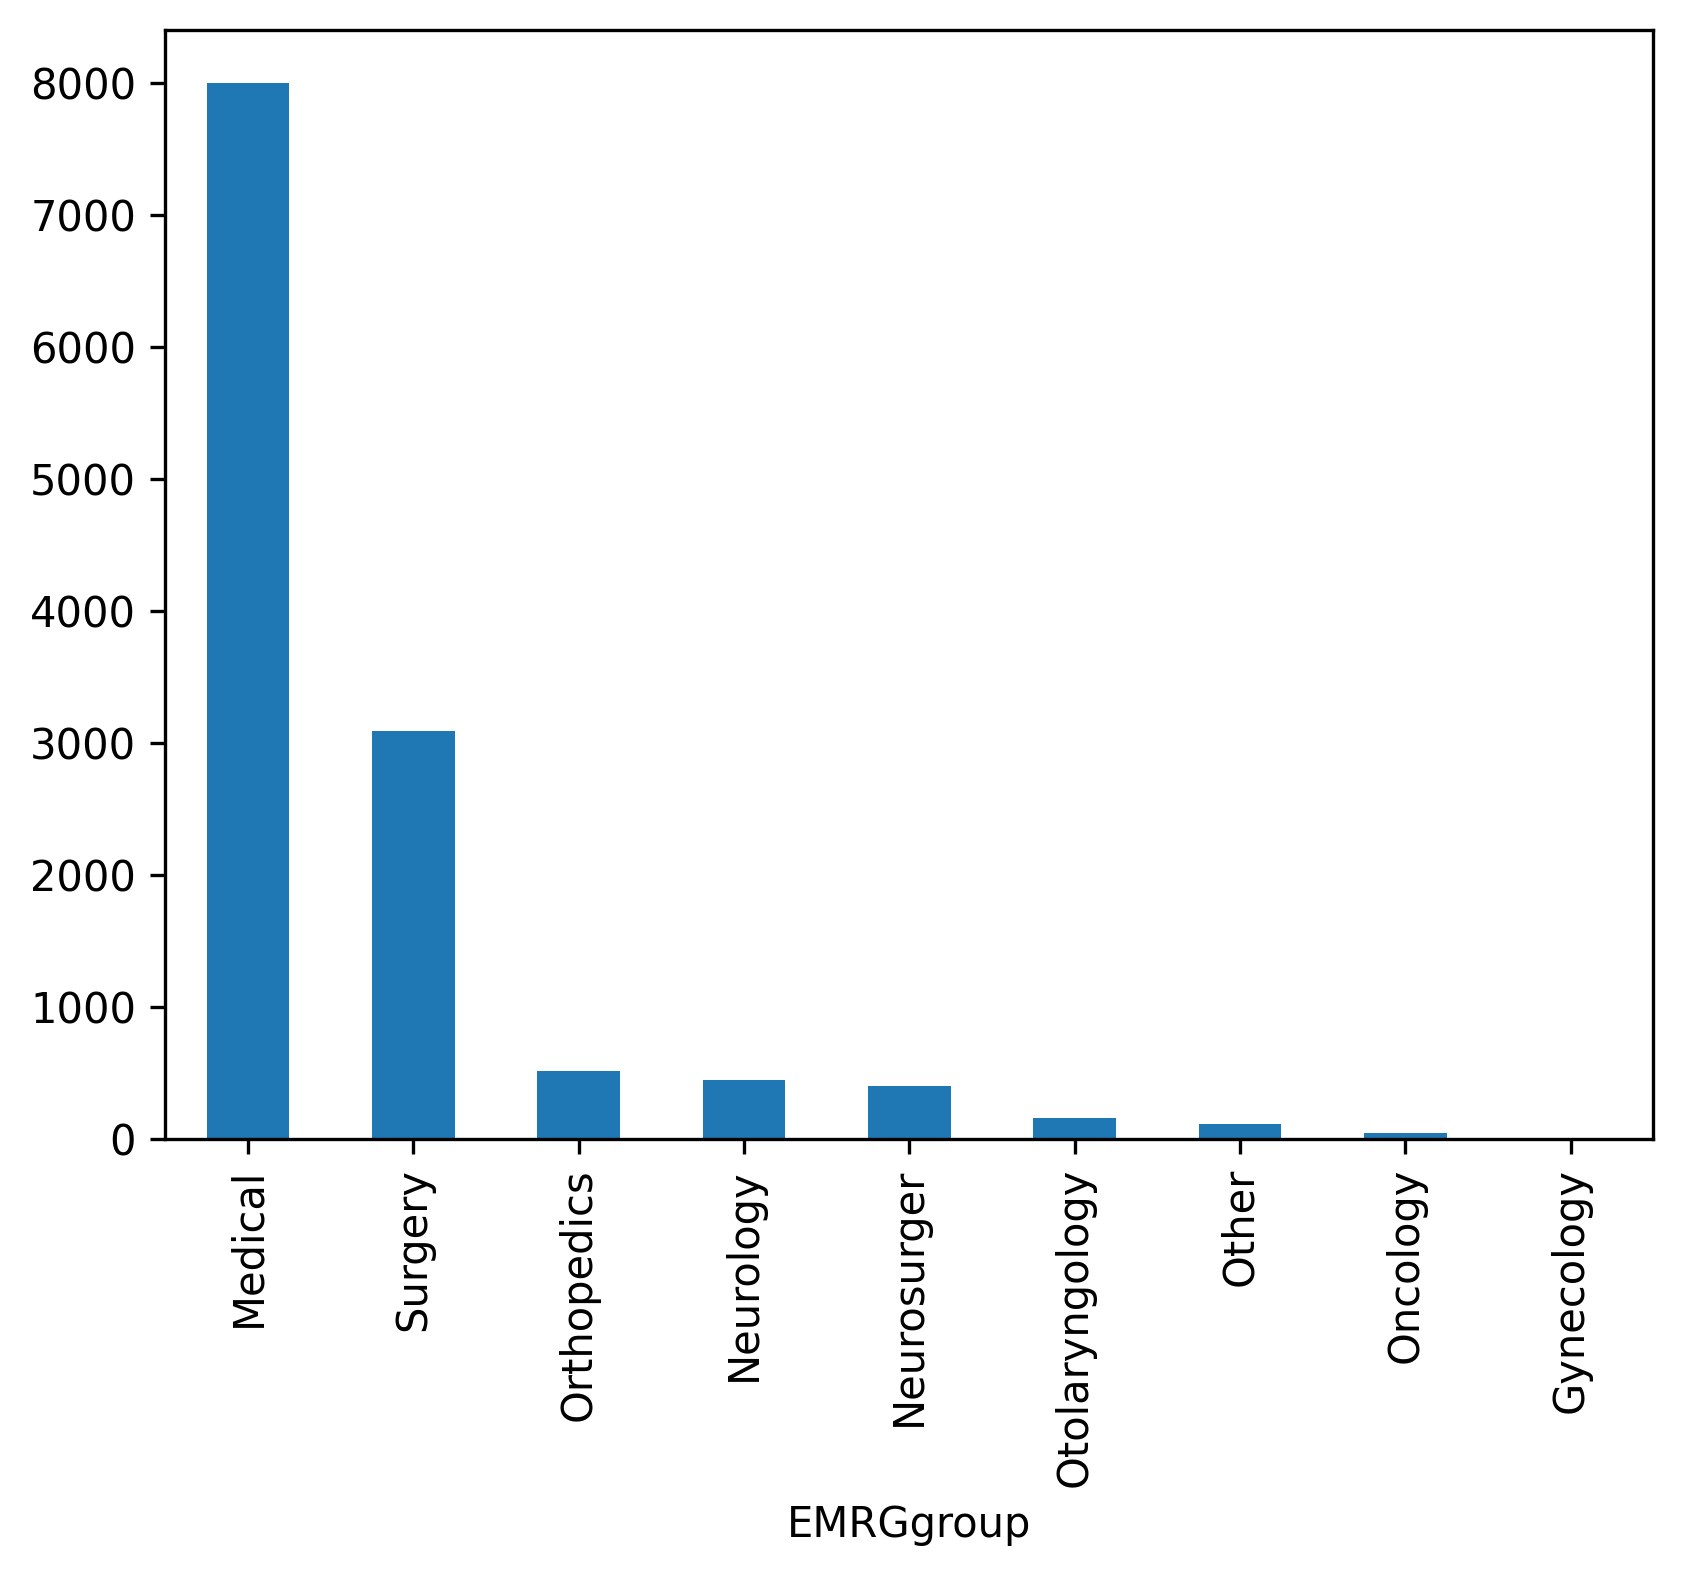

In [23]:

df_triage_t["EMRGgroup"] = df_triage_t.EMRGgroup.map(emr_map)
df_triage_t["EMRGgroup"].value_counts().plot(kind='bar')

In [24]:
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12770 entries, 2892 to 303893
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  object        
 3   Htriage                     12770 non-null  object        
 4   Dischgto                    12770 non-null  object        
 5   akdb_ESS                    12748 non-null  object        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  object        
 9   nimes_FagområdeBeskrivelse  12770 non-null  object        
 10  nimes_IK4489Kode            12770 non-null  object        
 11  nimes_IK4489Beskrivelse     12749 non-null  object     

### Group Age

In [25]:
df_triage_t.Age= df_triage_t.Age.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins = [0,18,30,40,50,60,70,80,90,100,200]
labels = ['0-17','18-29', '30-39','40-49','50-59','60-69','70-79','80-89','90-100','+100']
df_triage_t['AgeGrp'] = pd.cut(df_triage_t.Age, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})

In [26]:
#df_triage_t['AgeGrpDesc'].value_counts()
df_triage_t[df_triage_t['AgeGrp'].isnull()]

,akdb_InnAkutt,akdb_UtAkutt,EMRGgroup,Htriage,Dischgto,akdb_ESS,pasient_Fødselsdato,pasient_Dødsdato,Kjonn,nimes_FagområdeBeskrivelse,...,EDLOS,Age,30dmrt,24hmrt,DischICU,Time_in_h,Ukedag,Mrt_AND_OR_ICU,Dischhome,AgeGrp


In [27]:
#df_triage_t['AgeGrpDesc'].value_counts()

### Group Triage score

In [28]:
#df_triage_t['Htriage']= df_triage_t['Htriage'].astype(float).astype(int)
#df_triage_t['HtriageGrp'] = np.where(df_triage_t['Htriage']<3,1,0)
df_triage_t['HtriageGrp'] =df_triage_t.Htriage.map({'Grønn':'1'
                                                      ,'Blå':'1'
                                                       ,'Rød':'0'
                                                      ,'Oransje':'0'
                                                      ,'Gul':'1'


                                                     })
df_triage_t['HtriageGrpDesc'] =df_triage_t.Htriage.map({'Grønn':'Routine'
                                                      ,'Blå':'Routine'
                                                       ,'Rød':'Urgent'
                                                      ,'Oransje':'Urgent'
                                                      ,'Gul':'Routine'


                                                     })
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12770 entries, 2892 to 303893
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  object        
 3   Htriage                     12770 non-null  object        
 4   Dischgto                    12770 non-null  object        
 5   akdb_ESS                    12748 non-null  object        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  object        
 9   nimes_FagområdeBeskrivelse  12770 non-null  object        
 10  nimes_IK4489Kode            12770 non-null  object        
 11  nimes_IK4489Beskrivelse     12749 non-null  object     

[Text(0, 0, '94.2365'), Text(0, 0, '5.76351')]

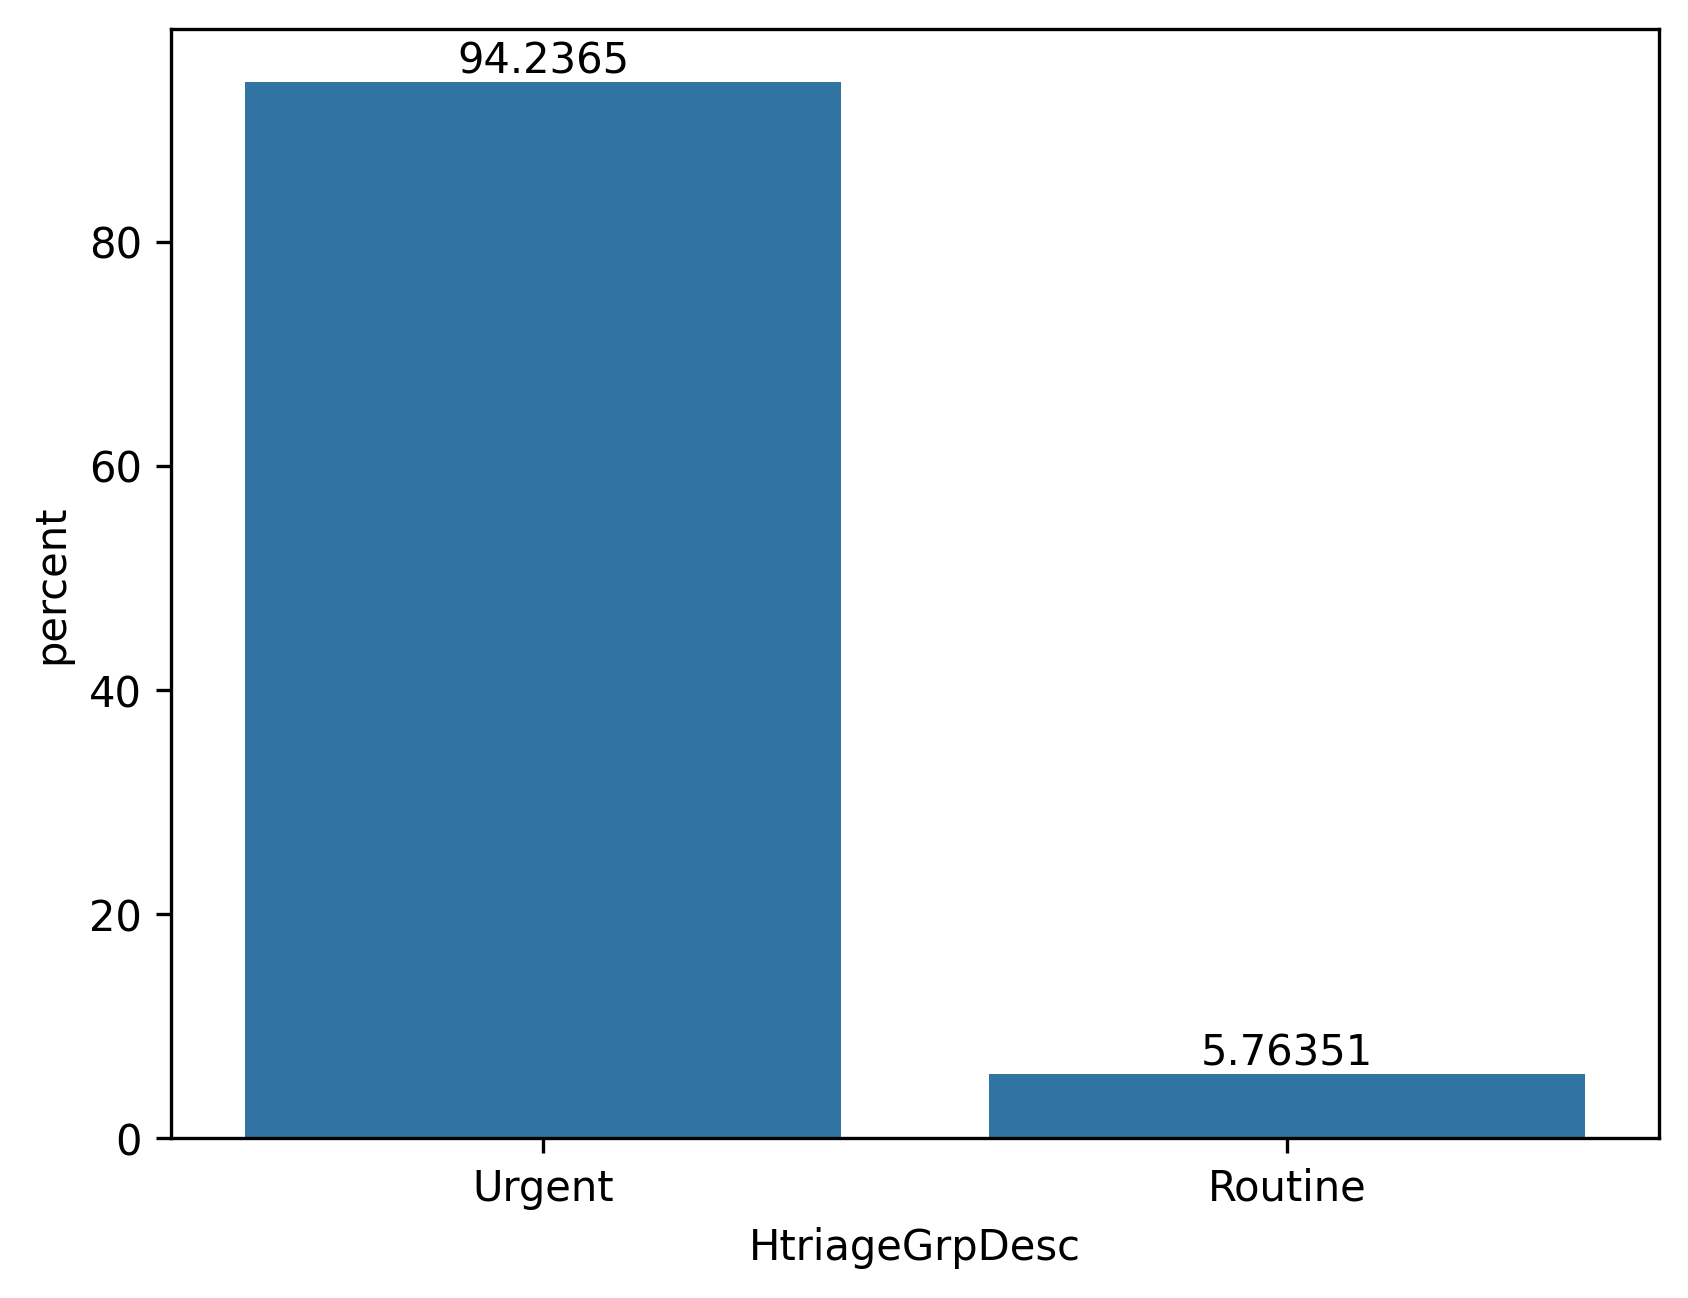

In [29]:
#df_triage_t['HtriageGrpDesc'].value_counts().plot(kind='bar')
#import seaborn as sns
ax = sns.countplot(df_triage_t, x = 'HtriageGrpDesc',stat="percent")
#This next line will label the top of the bar with the item counts
ax.bar_label(ax.containers[0])
#ax.set_xticklabels(('Urgent', 'Routine'))

## Group time of admission

In [30]:
df_triage_t.Time_in_h.value_counts()

Time_in_h
11.0    728
12.0    706
13.0    689
14.0    687
15.0    675
10.0    648
17.0    639
16.0    617
21.0    616
19.0    616
20.0    613
18.0    592
22.0    588
0.0     528
9.0     521
23.0    485
1.0     457
2.0     444
3.0     368
4.0     351
8.0     344
7.0     302
6.0     281
5.0     275
Name: count, dtype: int64

<Axes: xlabel='AdmtimeGrp'>

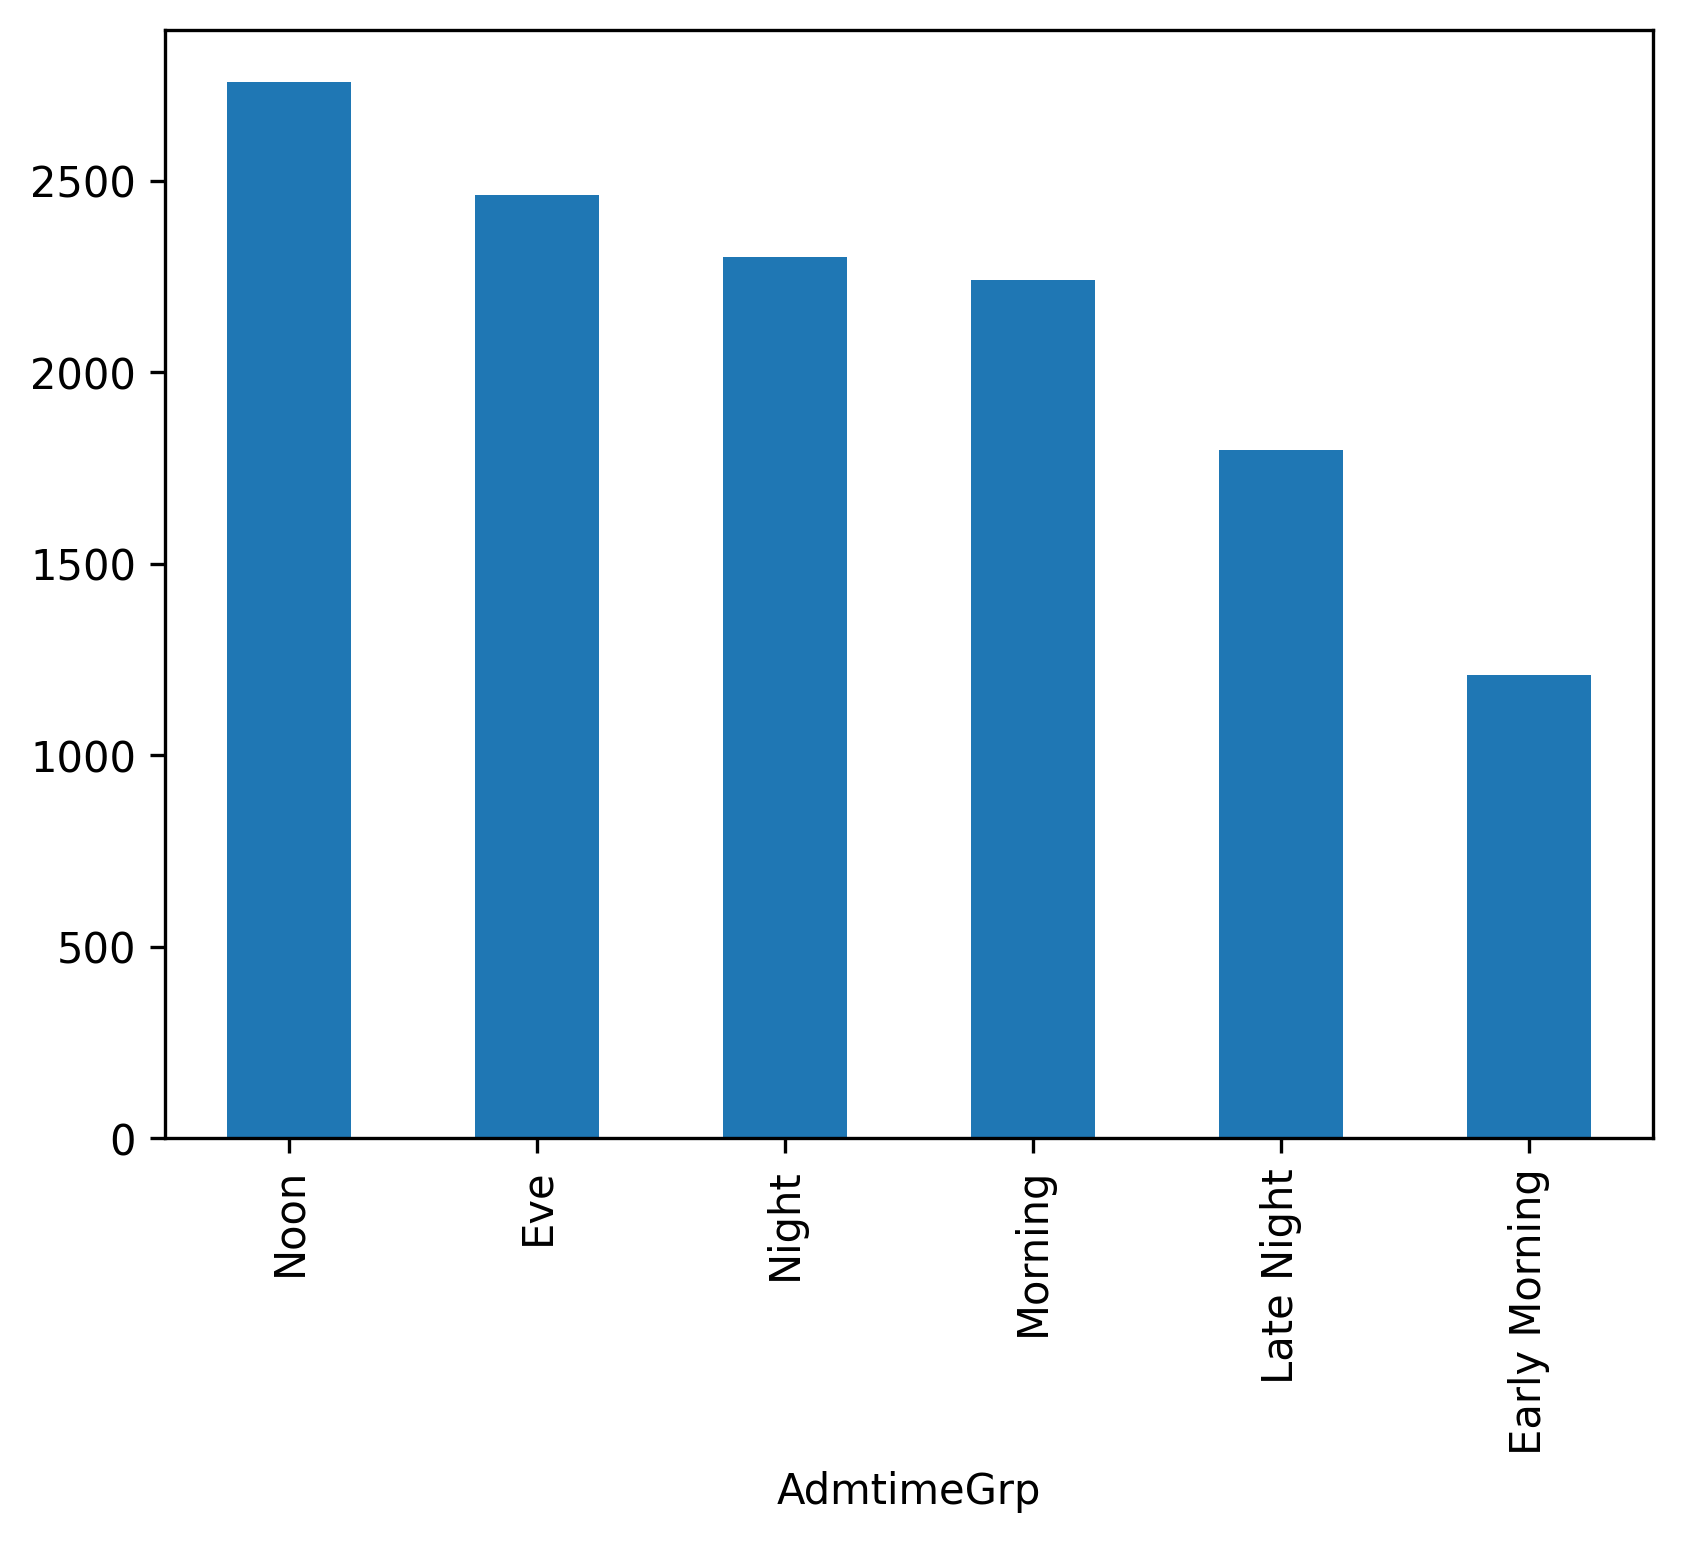

In [31]:
df_triage_t['Admtime']= df_triage_t.Time_in_h.astype(float).astype(int)
#df_triage_t=df_triage_t.loc[df_triage_t.Age>=18]
bins =  [0,4,8,12,16,20,24]
labels = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']
df_triage_t['AdmtimeGrp'] = pd.cut(df_triage_t.Admtime, bins, labels = labels,right=False)
#df_triage_t["AgeGrp"] = df_triage_t.AgeGrp.map({'0-12':0,'13-17':1, '20-64':2, '65+':3})
#df_triage_t["AgeGrpDesc"] = df_triage_t.AgeGrp.map({'0-12':'Children','13-17':'Teen', '18-64':'Adult', '65+':'Older'})
df_triage_t['AdmtimeGrp'].value_counts().plot(kind='bar')

<Axes: xlabel='AdmtimeGrp'>

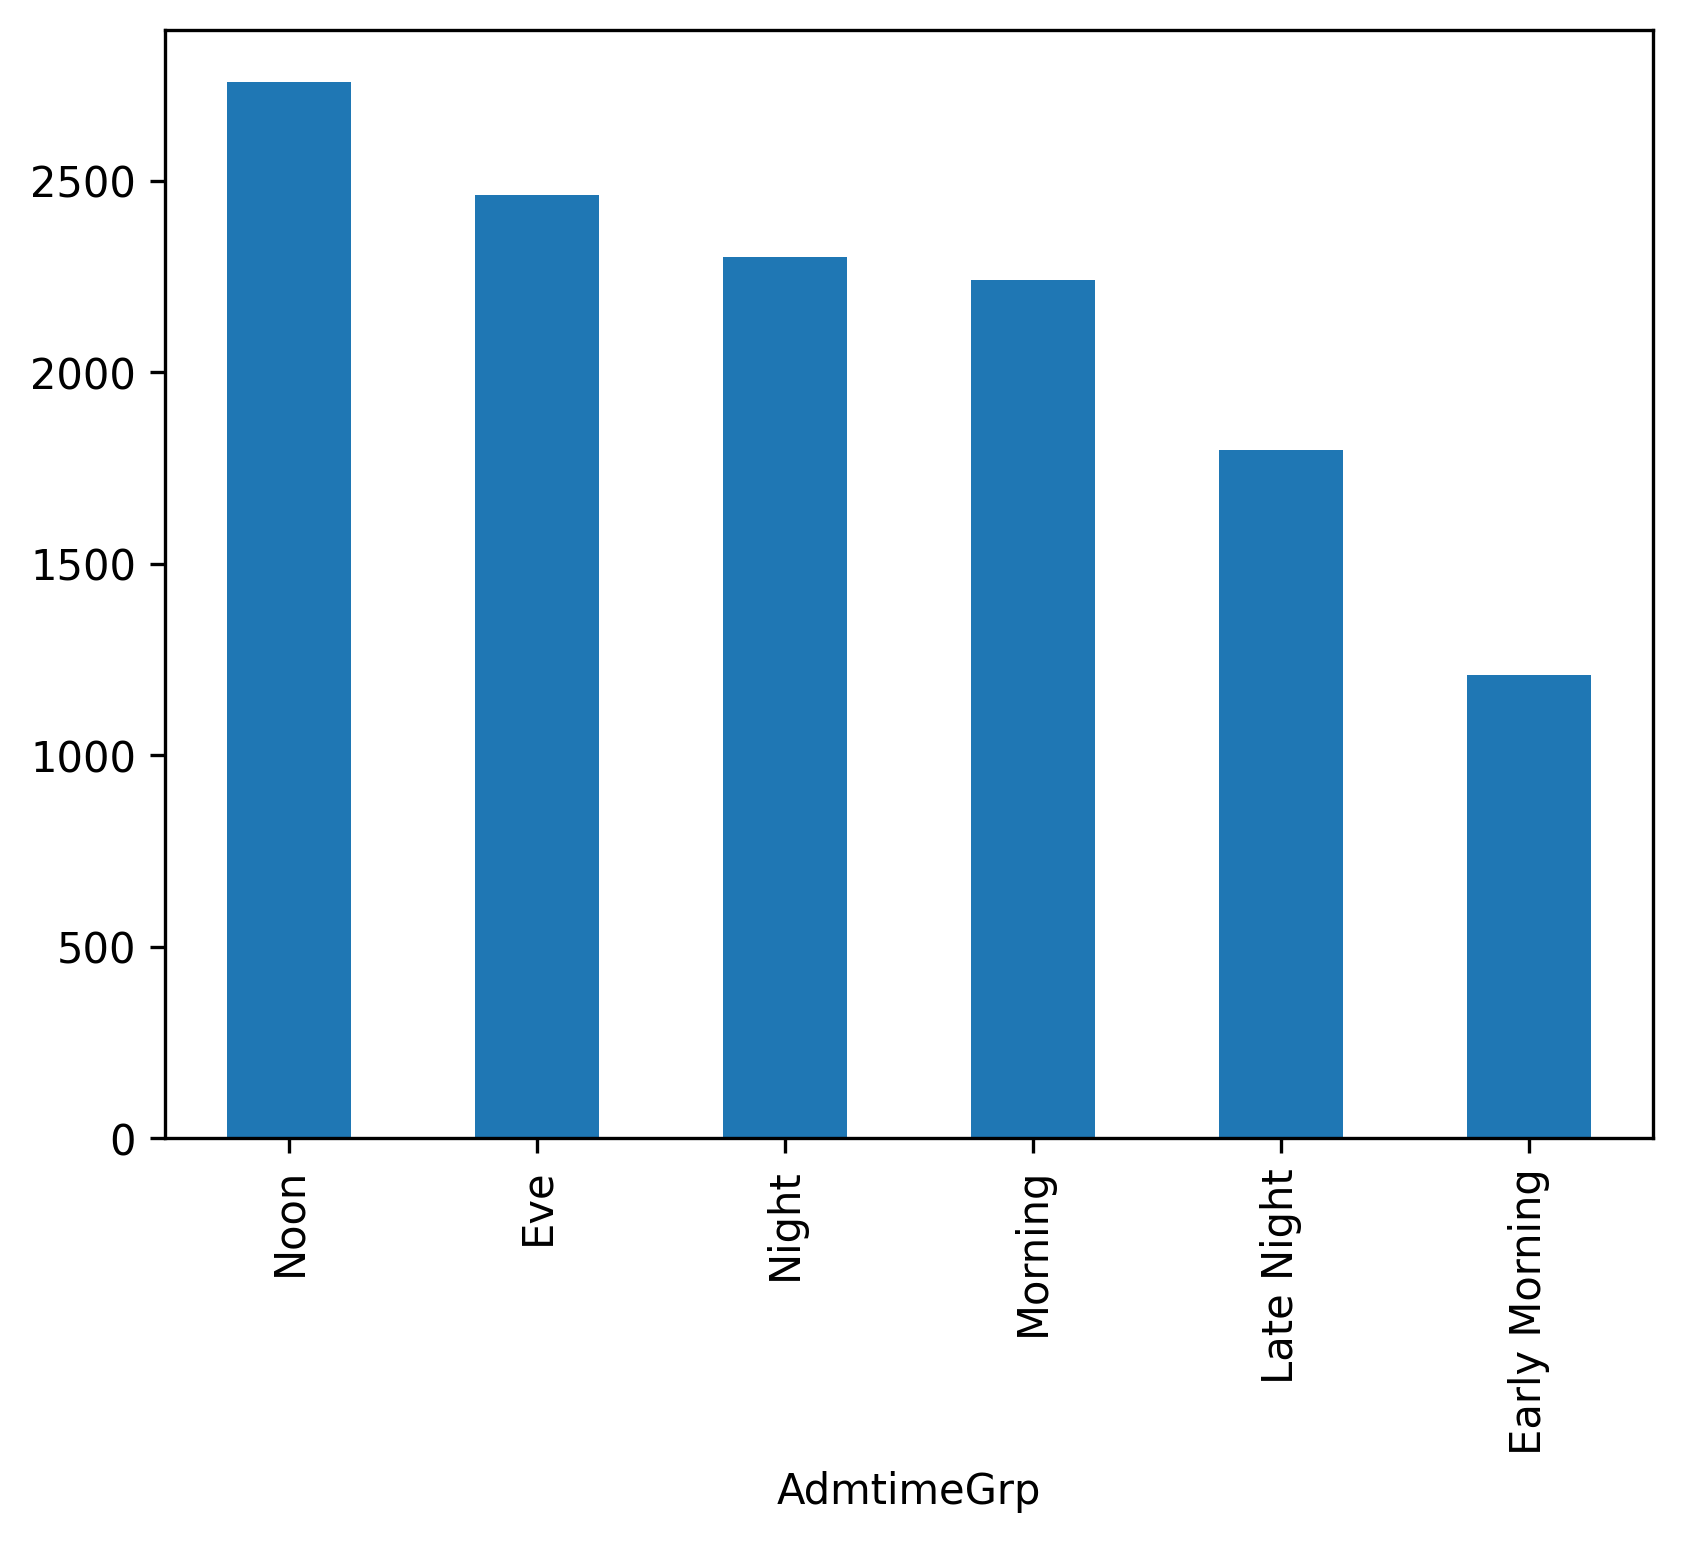

In [32]:
df_triage_t['AdmtimeGrp'].value_counts().plot(kind='bar')

In [33]:
for c in df_triage_t.select_dtypes(include='object'):
    df_triage_t[c] = df_triage_t[c].astype('string')
#df_triage_t[categorical_features].info()
df_triage_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12770 entries, 2892 to 303893
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   akdb_InnAkutt               12770 non-null  datetime64[ns]
 1   akdb_UtAkutt                12770 non-null  datetime64[ns]
 2   EMRGgroup                   12770 non-null  string        
 3   Htriage                     12770 non-null  string        
 4   Dischgto                    12770 non-null  string        
 5   akdb_ESS                    12748 non-null  string        
 6   pasient_Fødselsdato         12770 non-null  datetime64[ns]
 7   pasient_Dødsdato            5499 non-null   datetime64[ns]
 8   Kjonn                       12770 non-null  string        
 9   nimes_FagområdeBeskrivelse  12770 non-null  string        
 10  nimes_IK4489Kode            12770 non-null  string        
 11  nimes_IK4489Beskrivelse     12749 non-null  string     

## Classification evaluation

In [34]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import shap
shap.initjs()

In [35]:
features = ['HtriageGrp' ,
             # 'Dischgto'
            # 'Dischhome',
            #'DischICU',
            'EMRGgroup',
        'Kjonn', #'InICD10-chapter',
          #  'Aar' correlated to triagestmt
        #    'Mnd',
    #'Season',
      # 'DOW', #'Shift',# 'nprDiagn', 'Out_ICD10-chapter',
            'AgeGrp',
          #  '24hmrt',
      # '7dmrt', '30dmrt',
        #    'Triagestm',
           'AdmtimeGrp'
      # ,'Time_in_m'#, 'Time_out_h', 'Time_out_m'
           ]
nominal_features=[#'Dischgto',
                  #'Dischhome'#, 'DischICU'
                  'EMRGgroup', 'AdmtimeGrp',
        'Kjonn',  #'InICD10-chapter',
     #  'DOW', # 'nprDiagn', 'Out_ICD10-chapter',
    '24hmrt'#,'Season'
     #  ,'7dmrt', '30dmrt'
]
ordinal_features=[ #'HtriageGrp',

          #        'Aar'
                   #'Mnd',
      'AgeGrp', #'Time_in_h'# 'Time_in_h'#'Triagestm'
     # 'Shift'#, 'Time_in_m',
       #'Time_out_h', 'Time_out_m'
                 ]

In [36]:
data = df_triage_t[features]
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12770 entries, 2892 to 303893
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HtriageGrp  12770 non-null  string  
 1   EMRGgroup   12770 non-null  string  
 2   Kjonn       12770 non-null  string  
 3   AgeGrp      12770 non-null  category
 4   AdmtimeGrp  12770 non-null  category
dtypes: category(2), string(3)
memory usage: 424.6 KB


In [37]:
#load data
data = df_triage_t[features]

#get features
y = data['HtriageGrp']
y = y.astype('category').cat.codes
X_cat = data.drop('HtriageGrp', axis=1)

In [38]:
#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12770 entries, 0 to 12769
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EMRGgroup_Gynecology      12770 non-null  float64
 1   EMRGgroup_Medical         12770 non-null  float64
 2   EMRGgroup_Neurology       12770 non-null  float64
 3   EMRGgroup_Neurosurger     12770 non-null  float64
 4   EMRGgroup_Oncology        12770 non-null  float64
 5   EMRGgroup_Orthopedics     12770 non-null  float64
 6   EMRGgroup_Other           12770 non-null  float64
 7   EMRGgroup_Otolaryngology  12770 non-null  float64
 8   EMRGgroup_Surgery         12770 non-null  float64
 9   Kjonn_Kvinne              12770 non-null  float64
 10  Kjonn_Mann                12770 non-null  float64
 11  AgeGrp_+100               12770 non-null  float64
 12  AgeGrp_0-17               12770 non-null  float64
 13  AgeGrp_18-29              12770 non-null  float64
 14  AgeGrp

In [39]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)
#class_weight=int(y.value_counts()[0]/y.value_counts()[1])

## Choosing a model 

In [40]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier

In [41]:
def model_train(model,X, y, param,smote=True):
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=11)
    sm = SMOTE()
    if smote == True:
        #pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
         #                               ['scaler', MinMaxScaler()],
          #                              ['classifier', model]])


        X_train, y_train = sm.fit_resample(X_train, y_train)

    #else:
        #smote = SMOTE(random_state = 11)
        #X_train, y_train = smote.fit_resample(X_train, y_train)
        #pipeline = Pipeline(steps = [['scaler', MinMaxScaler()],
                                     #['classifier', model]])


    stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)


    param_grid = param
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='roc_auc',
                               cv=stratified_kfold,
                               n_jobs=-1)


    grid_search.fit(X_train, y_train)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, y_test)
    return {'clf':grid_search,'model':type(model).__name__,'SMOTE':smote,'cv_score':cv_score, 'test_score':test_score}

In [42]:
model = LogisticRegression(random_state=11, max_iter=1000)
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_dict = model_train(model,X,y,param_grid,True)
model_lr_smote = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=LogisticRegression(max_iter=1000, random_state=11),
              n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              scoring='roc_auc'),
 'model': 'LogisticRegression',
 'SMOTE': True,
 'cv_score': 0.6668956997251915,
 'test_score': 0.5987885586793849}

In [43]:
model = LogisticRegression(random_state=11, max_iter=1000,class_weight="balanced")
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_dict = model_train(model,X,y,param_grid,False)
model_lr = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=LogisticRegression(class_weight='balanced',
                                           max_iter=1000, random_state=11),
              n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
              scoring='roc_auc'),
 'model': 'LogisticRegression',
 'SMOTE': False,
 'cv_score': 0.6381679714228057,
 'test_score': 0.6061399330667704}

In [44]:
model =RandomForestClassifier(n_estimators=150, random_state=0)
param_grid = {'n_estimators': [200, 500],
    'max_features': [None,'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
model_dict = model_train(model,X,y,param_grid,True)
model_rf_smote = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=RandomForestClassifier(n_estimators=150, random_state=0),
              n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [None, 'sqrt', 'log2'],
                          'n_estimators': [200, 500]},
              scoring='roc_auc'),
 'model': 'RandomForestClassifier',
 'SMOTE': True,
 'cv_score': 0.8485752528065383,
 'test_score': 0.6001999222872614}

In [45]:
from sklearn.utils import class_weight
# A array object that contains the weights for both classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
# A dictionary object containing key-value pairs of both classes and # their weights
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

model =RandomForestClassifier(n_estimators=150, random_state=0,class_weight=class_weights_dict)
param_grid = {'n_estimators': [200, 500],
    'max_features': [ None,'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
model_dict = model_train(model,X,y,param_grid,False)
model_rf = model_dict['clf']
model_dict

{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=RandomForestClassifier(class_weight={0: 0.530580023267409,
                                                             1: 8.675271739130435},
                                               n_estimators=150,
                                               random_state=0),
              n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': [4, 5, 6, 7, 8],
                          'max_features': [None, 'sqrt', 'log2'],
                          'n_estimators': [200, 500]},
              scoring='roc_auc'),
 'model': 'RandomForestClassifier',
 'SMOTE': False,
 'cv_score': 0.6396171078311987,
 'test_score': 0.6108108446873316}

In [46]:
model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    )

param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
        
        'gamma':  [i/10.0 for i in range(3)],
        
        'colsample_bytree': [i/10.0 for i in range(1, 3)],
        'max_depth': range(3, 10)
        }
model_dict = model_train(model,X,y,param_grid,True)
model_xgb_smote = model_dict['clf']
model_dict


{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_typ...
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=600,
                                      n_jobs=None, num_parallel_tree=None,
                                  

In [47]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y
)

model = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    )

param_grid = {'scale_pos_weight' : class_weights,
    'n_estimators': [50, 100, 150, 200,],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
        
        'gamma':  [i/10.0 for i in range(3)],
        
        'colsample_bytree': [i/10.0 for i in range(1, 3)],
        'max_depth': range(3, 10)
        }
model_dict = model_train(model,X,y,param_grid,False)
model_xgb = model_dict['clf']
model_dict


{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_typ...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=600,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_jobs=-1,
              param_grid

In [48]:
model =  DecisionTreeClassifier(random_state=1024)
        

param_grid = {'max_features': [None ,'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
model_dict = model_train(model,X,y,param_grid,True)
model_lgb_smote = model_dict['clf']
model_dict



{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=DecisionTreeClassifier(random_state=1024), n_jobs=-1,
              param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 6, 7, 8, 9],
                          'max_features': [None, 'sqrt', 'log2']},
              scoring='roc_auc'),
 'model': 'DecisionTreeClassifier',
 'SMOTE': True,
 'cv_score': 0.7716321351325569,
 'test_score': 0.5290933931637859}

In [49]:
model =  DecisionTreeClassifier(random_state=1024,class_weight="balanced")
        

param_grid = {'max_features': [None ,'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
model_dict = model_train(model,X,y,param_grid,False)
model_lgb_smote = model_dict['clf']
model_dict



{'clf': GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=11, shuffle=True),
              estimator=DecisionTreeClassifier(class_weight='balanced',
                                               random_state=1024),
              n_jobs=-1,
              param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                          'criterion': ['gini', 'entropy'],
                          'max_depth': [5, 6, 7, 8, 9],
                          'max_features': [None, 'sqrt', 'log2']},
              scoring='roc_auc'),
 'model': 'DecisionTreeClassifier',
 'SMOTE': False,
 'cv_score': 0.6391566895323182,
 'test_score': 0.596890863739487}

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=11)


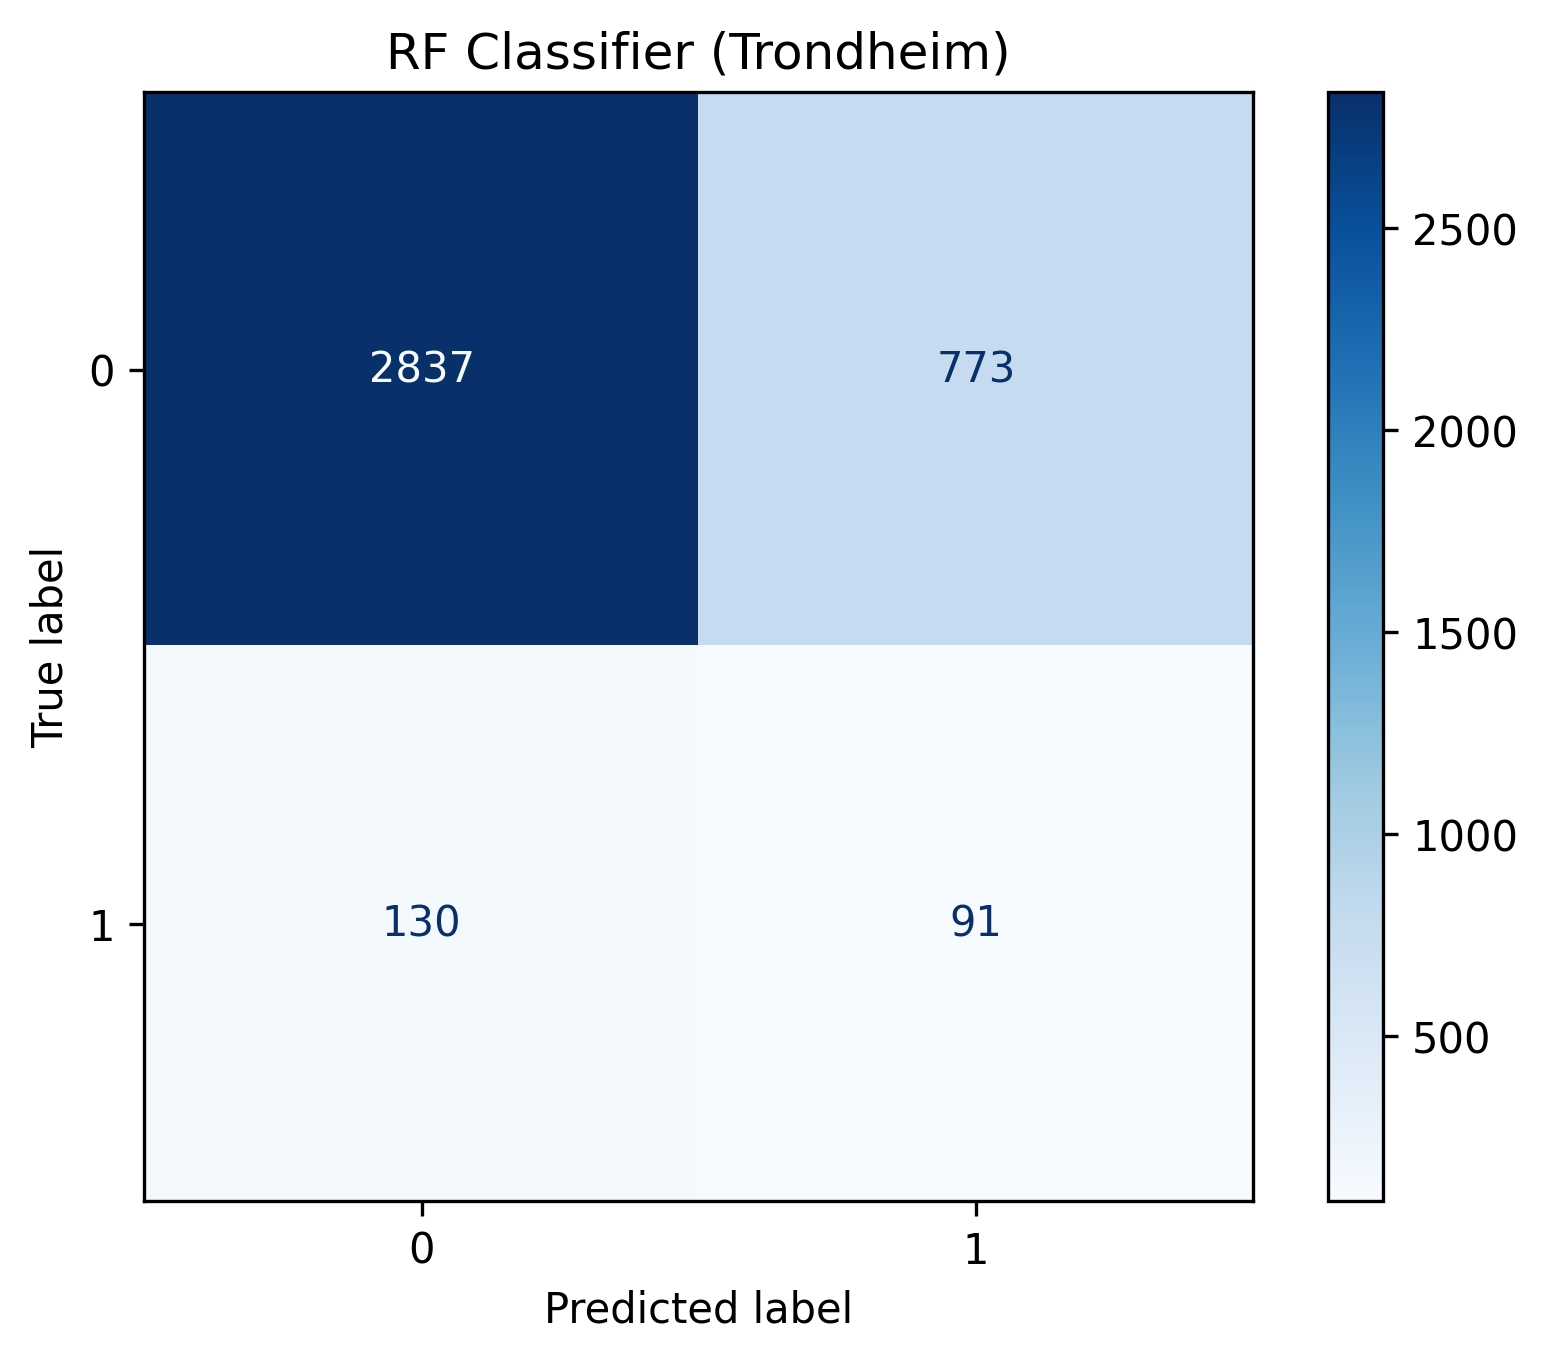

In [51]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,PrecisionRecallDisplay


        
y_pred = model_rf.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test,
                                             y_pred,

                                             #display_labels=target_names,
                                             cmap=plt.cm.Blues,
                                             normalize=None
                                            )
    #disp = PrecisionRecallDisplay.from_predictions(y_test, predictions_train[i],name=i)

#plt.title(i)
    #print(cm)
    #print(classification_report(y_test, predictions_test[i]),'\n')
plt.title('RF Classifier (Trondheim)')
plt.show()

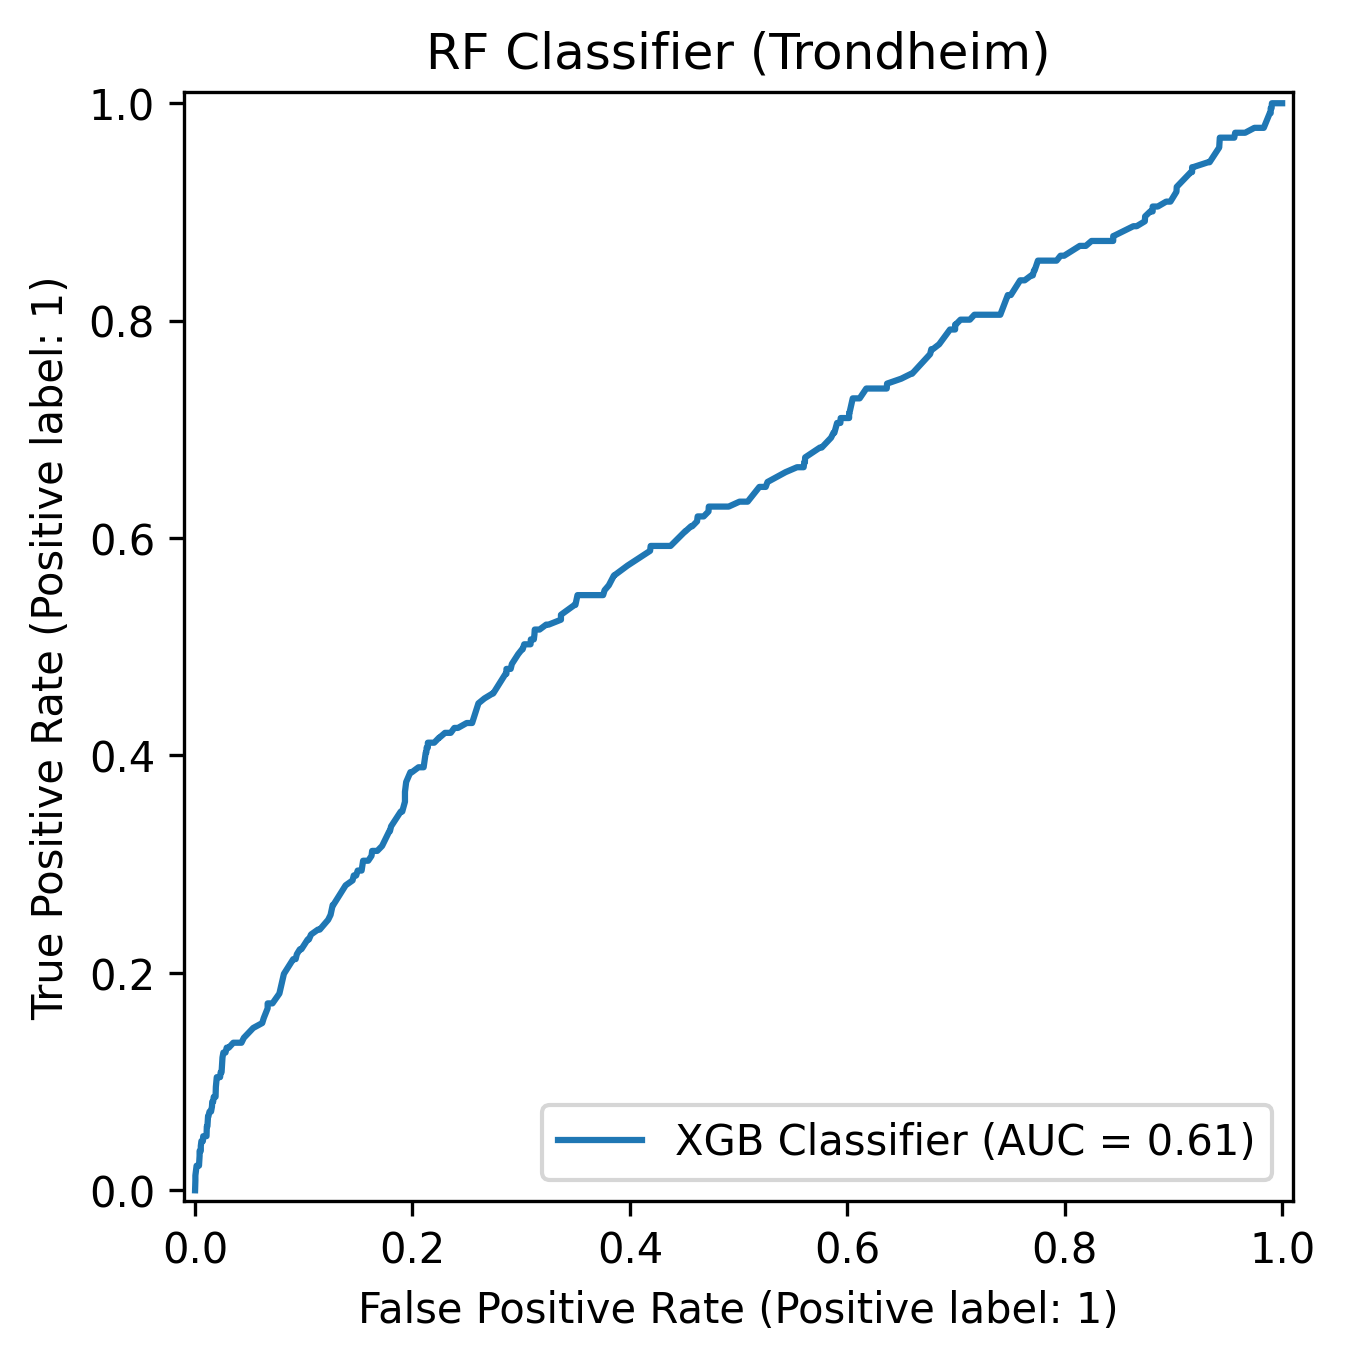

In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay

    
y_pred = model_rf.predict_proba(X_test)[:,1]

disp = RocCurveDisplay.from_predictions(y_test, y_pred,name="XGB Classifier")    #disp = PrecisionRecallDisplay.from_predictions(y_test, predictions_train[i],name=i)

#plt.title(i)
    #print(cm)
    #print(classification_report(y_test, predictions_test[i]),'\n')
plt.title('RF Classifier (Trondheim)')
plt.show()

### Standard SHAP values

In [53]:
# get shap values
#pip = clf.models['XGBClassifier']
model = model_rf.best_estimator_
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)[:,:,1]

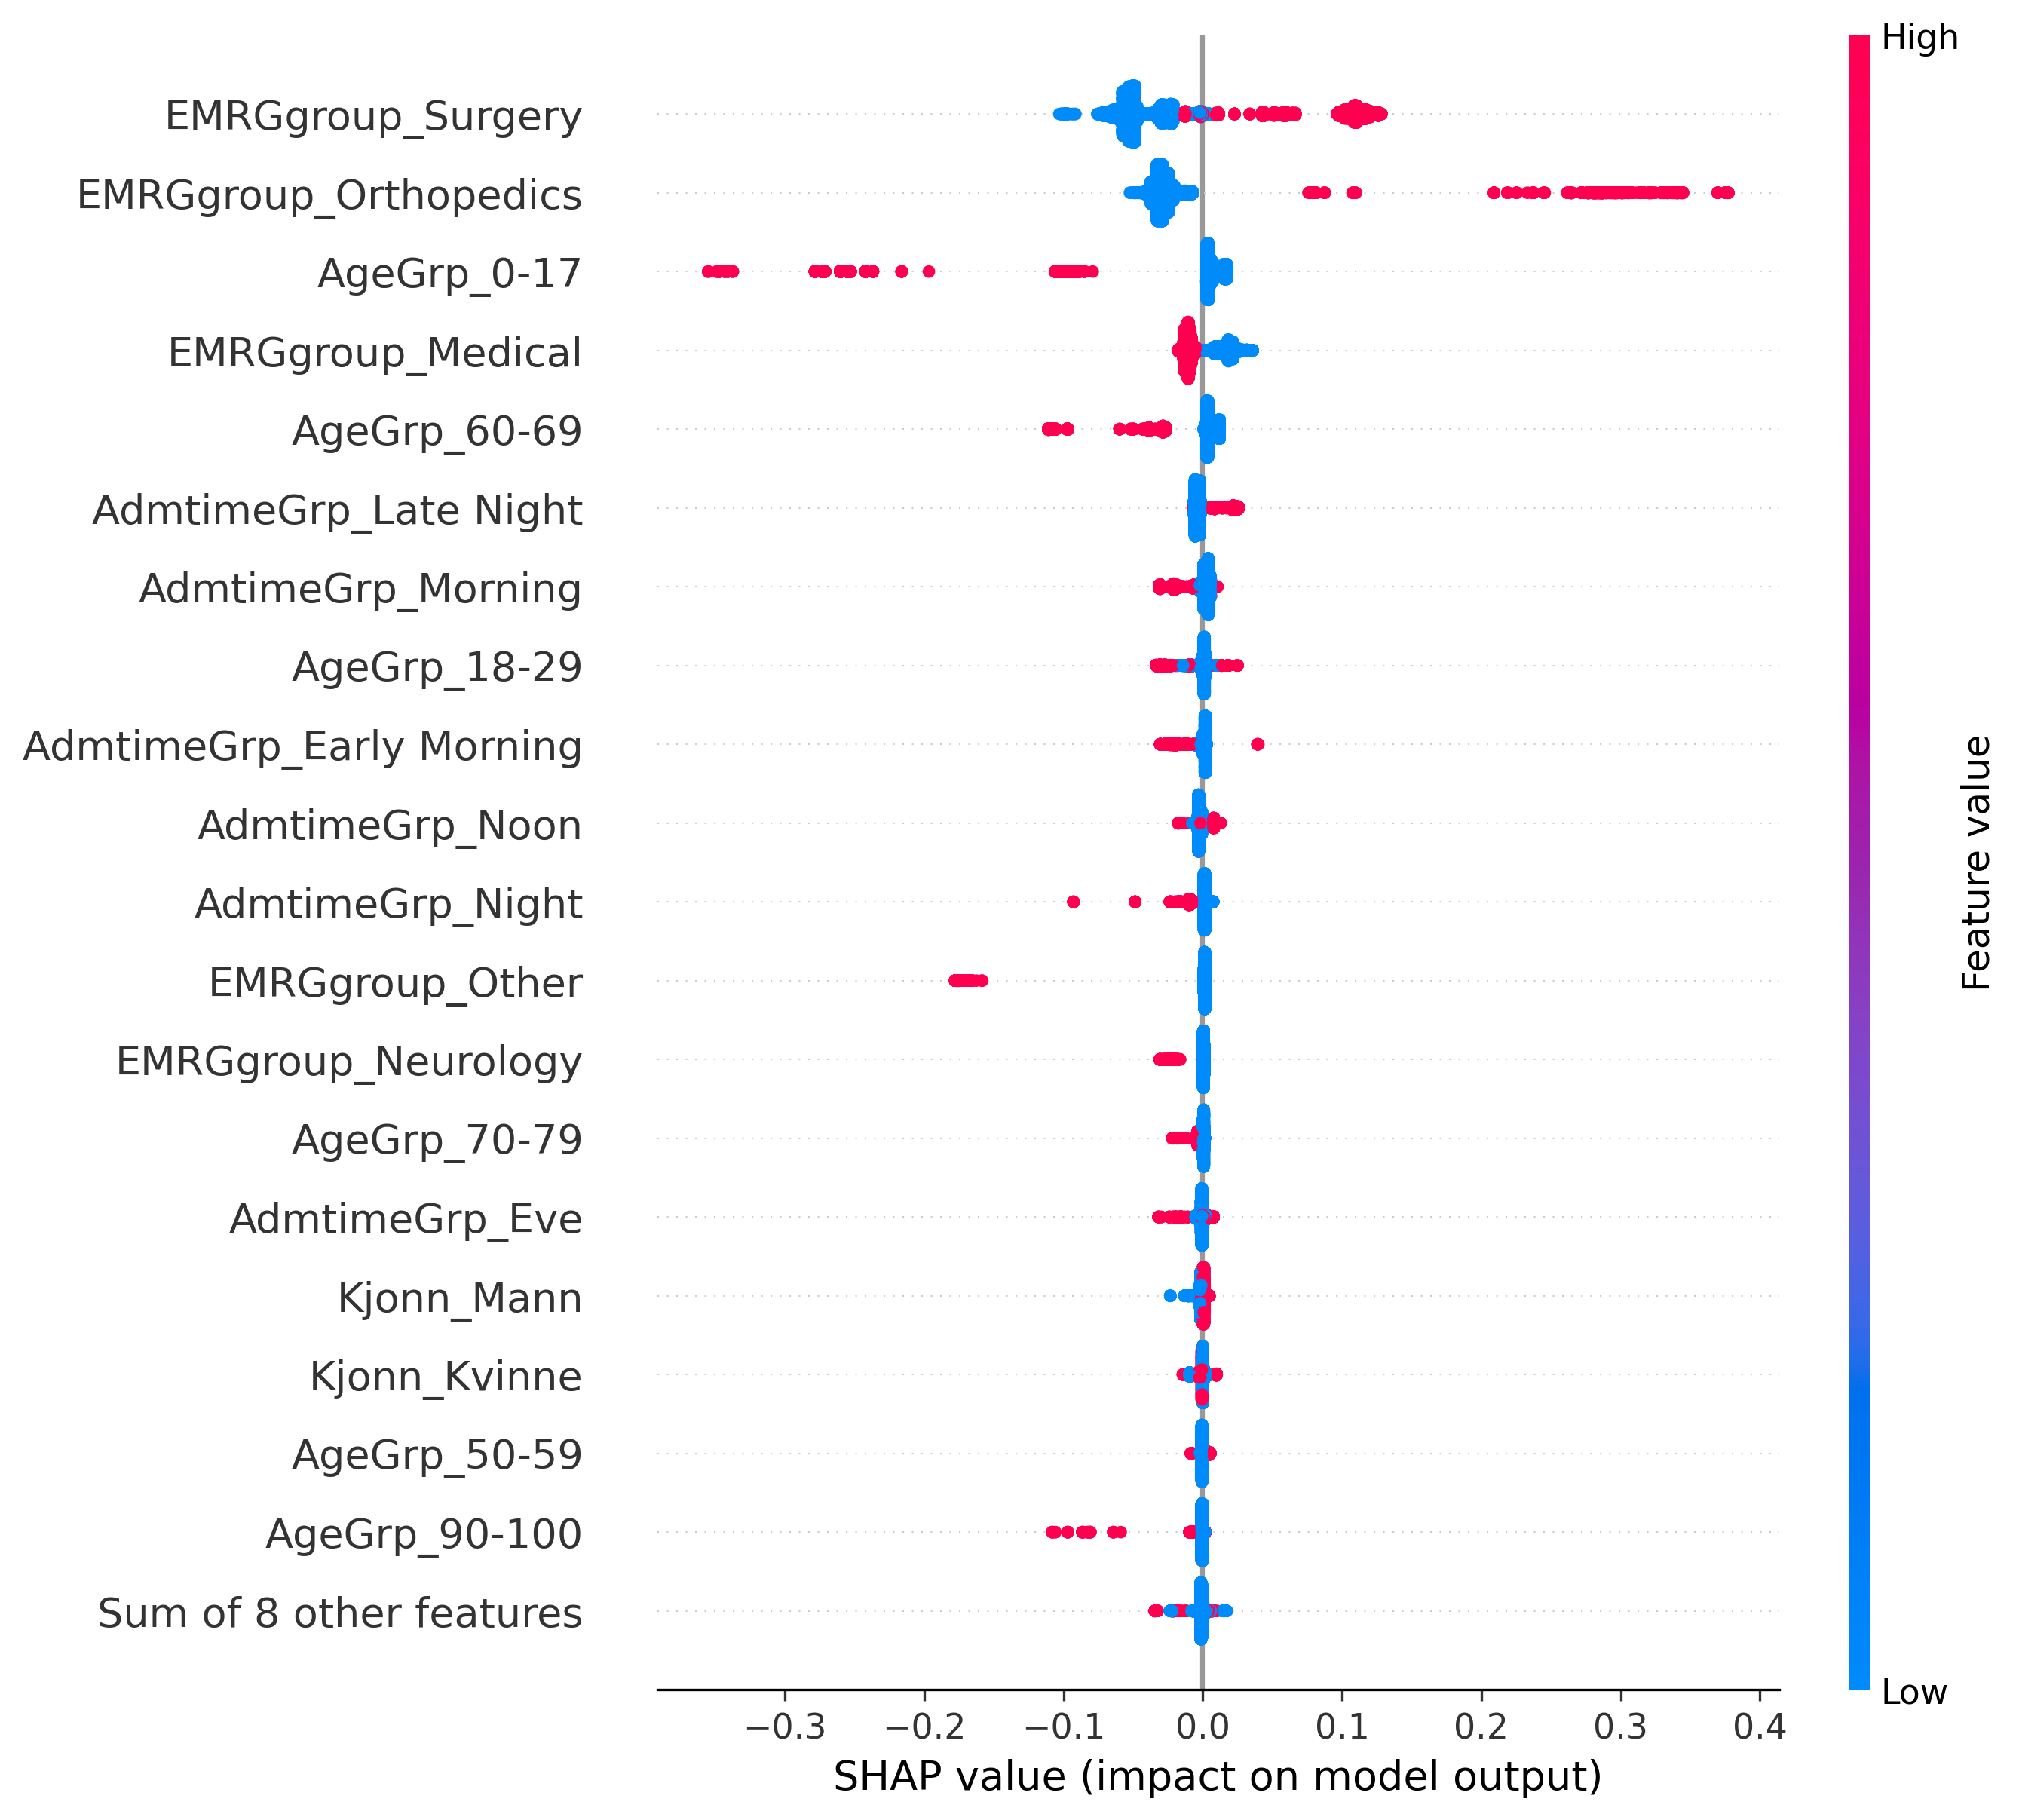

In [54]:
shap.plots.beeswarm(shap_values , max_display=20)

In [55]:
shap_values.data.shape

(12770, 27)

In [56]:
shap_values


.values =
array([[ 0.        ,  0.01304428,  0.00093609, ...,  0.00290773,
         0.00117687,  0.00589487],
       [ 0.        , -0.00842495,  0.00066701, ...,  0.00278281,
        -0.00967697, -0.00209665],
       [ 0.        , -0.00915829,  0.00068363, ...,  0.00523511,
        -0.0097838 , -0.00273613],
       ...,
       [ 0.        , -0.01010837,  0.00069623, ...,  0.00350291,
         0.00152035, -0.00297761],
       [ 0.        , -0.00907672,  0.0007995 , ...,  0.0050942 ,
        -0.00995375, -0.00271772],
       [ 0.        , -0.01123656,  0.00081942, ...,  0.00292247,
         0.00163069,  0.00702522]])

.base_values =
array([0.50014038, 0.50014038, 0.50014038, ..., 0.50014038, 0.50014038,
       0.50014038])

.data =
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.]])

### SHAP for categorical features

add the SHAP values for each categorical feature together.

In [57]:
#get number of unique categories for each feature
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)
print(n_categories)

[9, 2, 10]


In [58]:
import math

new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    #print(values_split)
    #sum values within each list
    values_sum = [math.fsum(l) for l in values_split]
    
    new_shap_values.append(values_sum)
np.shape(new_shap_values)

(12770, 4)

In [59]:

#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)

#update feature names
shap_values.feature_names = list(X_cat.columns)

Text(0.5, 1.08, '(B) Trondheim ')

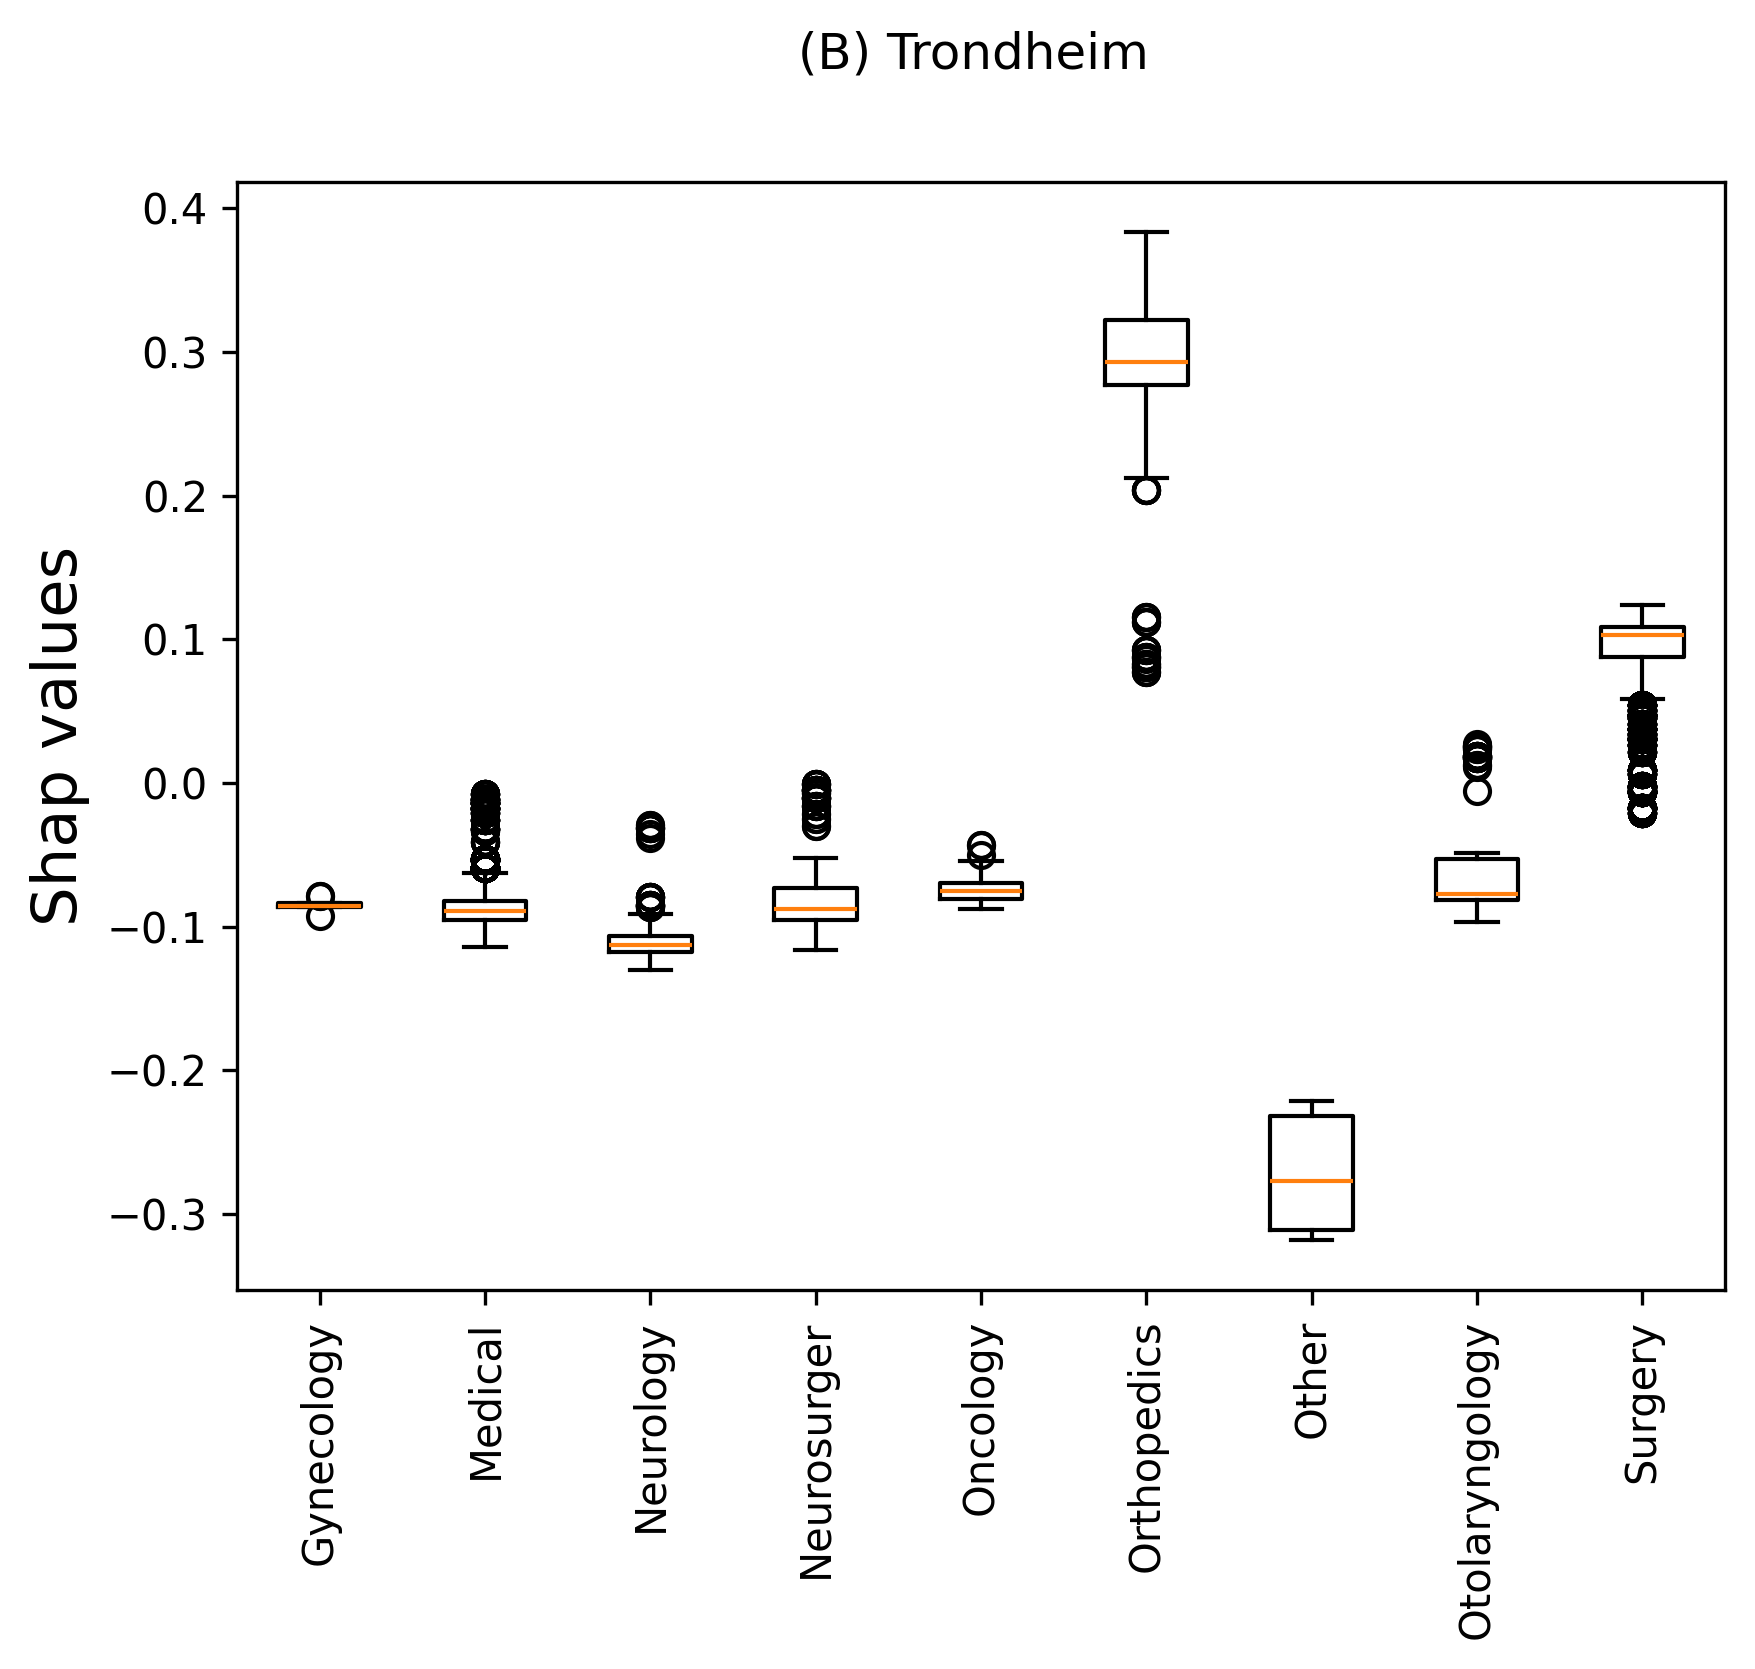

In [60]:
#split EMRGgroup shap values based on EMRGgroup values

emrg_values = shap_values[:,"EMRGgroup"].values
emrg_data = shap_values[:,'EMRGgroup'].data
emrg_categories = sorted(list(set(emrg_data)), key=str.lower)

emrg_groups = []
for o in emrg_categories:
    relevant_values = emrg_values[emrg_data == o]
    emrg_groups.append(relevant_values)


labels =emrg_categories
#labels= [Emrg_labels[u] for u in emrg_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

plt.boxplot(emrg_groups,labels=labels,manage_ticks=True)


plt.ylabel('Shap values',size=15)
#plt.xlabel('Emergency_Group',size=15)
plt.title('(B) Trondheim ', y=1.08)

split AgeGrp shap values based on AgeGrp values

Text(0.5, 1.08, '(B) Trondheim ')

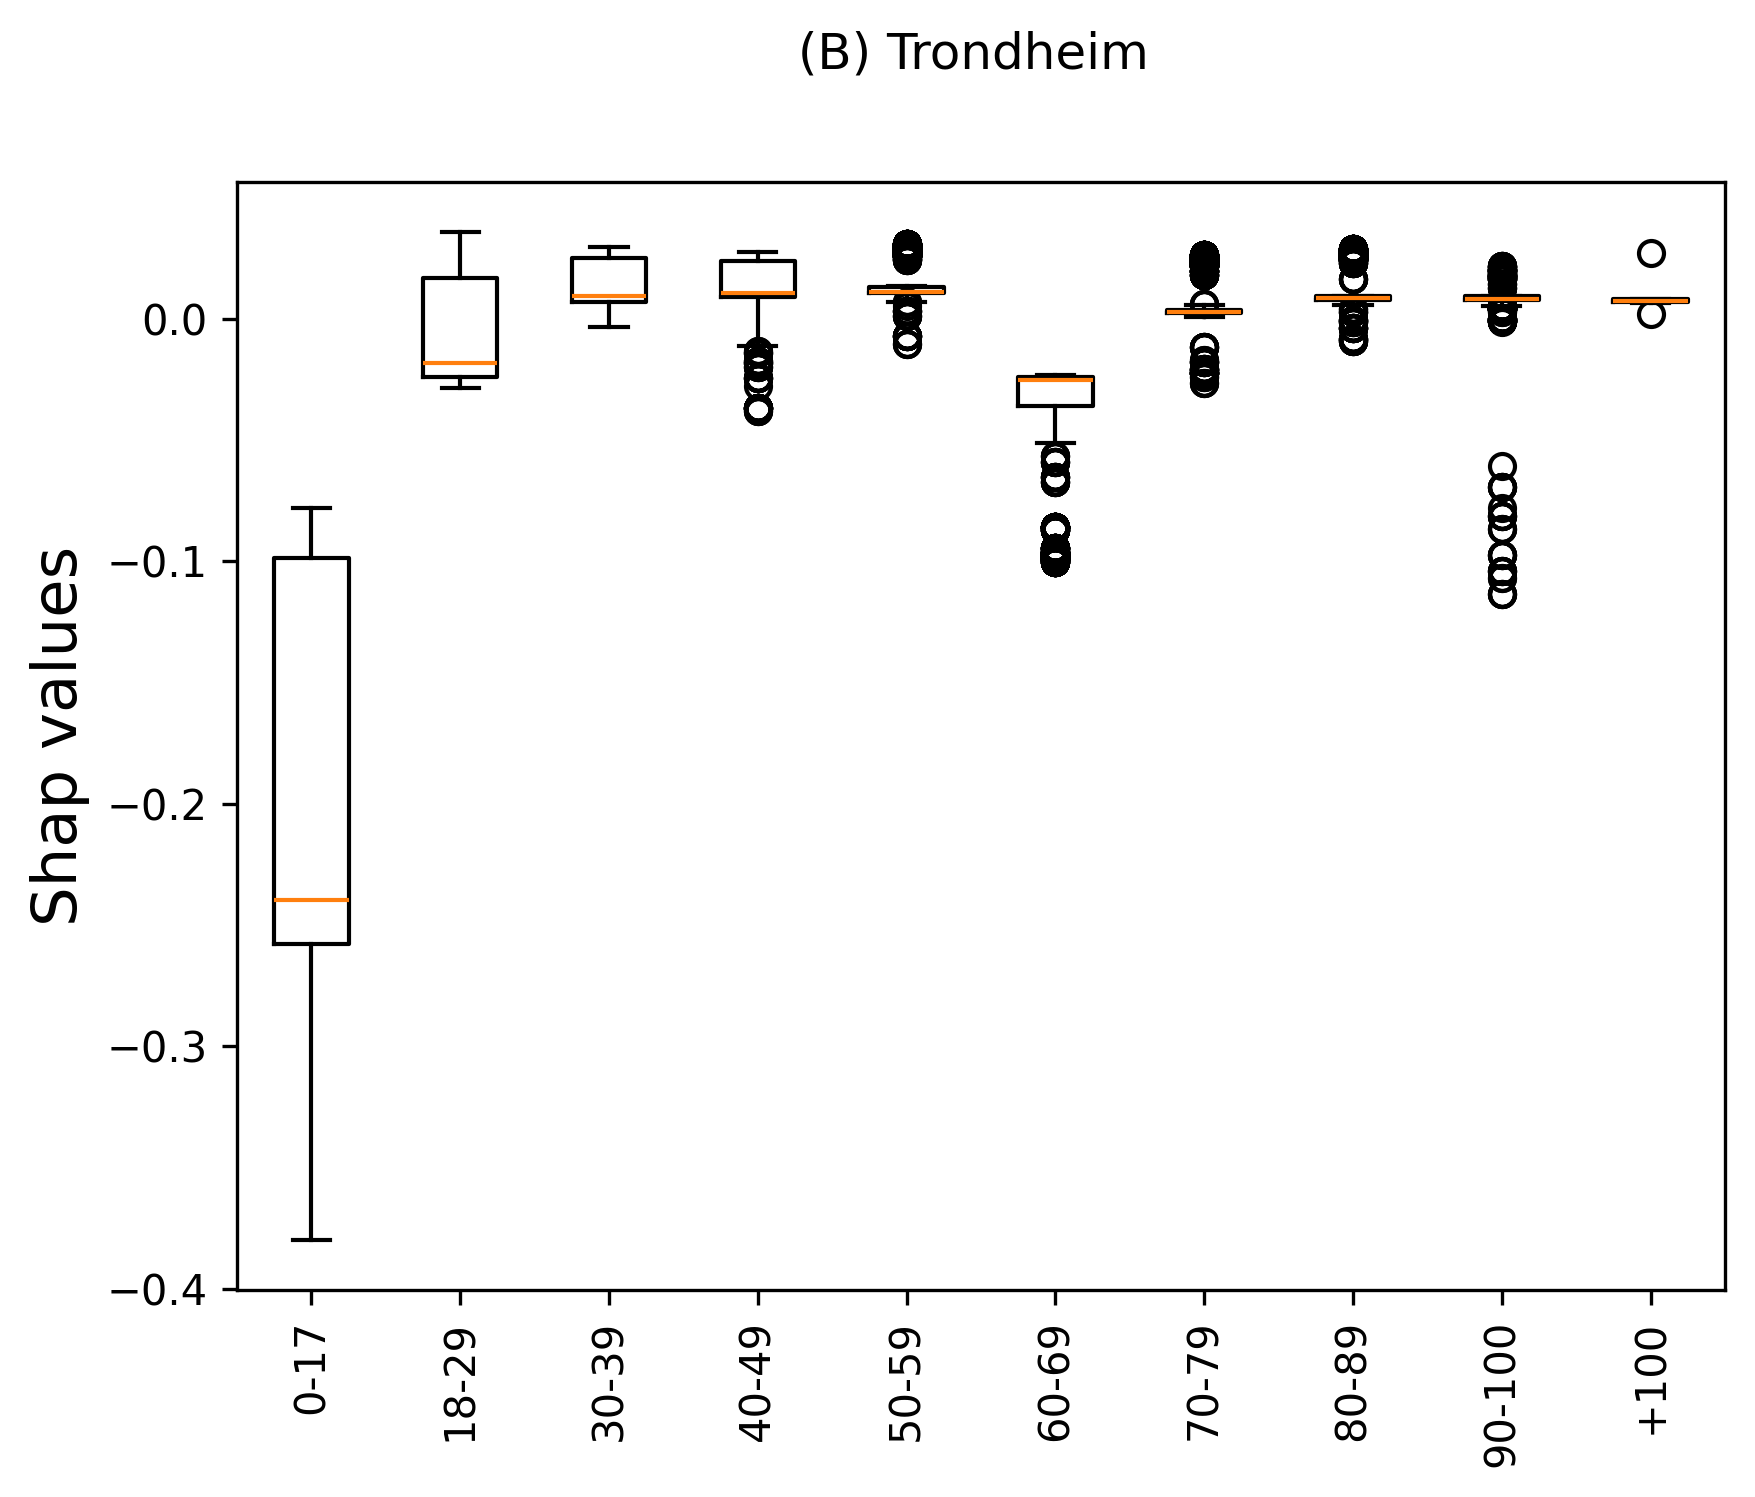

In [61]:
age_values = shap_values[:,"AgeGrp"].values
age_data = shap_values[:,"AgeGrp"].data
age_categories = list(set(age_data))
#print(age_categories)
age_categories = ['0-17','18-29', '30-39', '40-49', '50-59', '60-69', '70-79','80-89','90-100','+100']
age_groups = []
for o in age_categories:
    relevant_values = age_values[age_data == o]
    #print(o)
    age_groups.append(relevant_values)


labels = age_categories
#labels= [ageGrp_labels[u] for u in ageGrp_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

plt.boxplot(age_groups,labels=labels,manage_ticks=True)
#ax.set(xticklabels=labels)
#sns.boxplot(data=ageGrp_groups,order=columns_my_order)

#plt.boxplot(ageGrp_groups,labels=labels)

plt.ylabel('Shap values',size=15)
#plt.xlabel('AgeGroup',size=15)
plt.title('(B) Trondheim ', y=1.08)

In [62]:
timeinH_categories=['Early Morning','Morning', 'Noon',   'Eve','Night', 'Late Night']

Text(0.5, 1.08, '(B) Trondheim ')

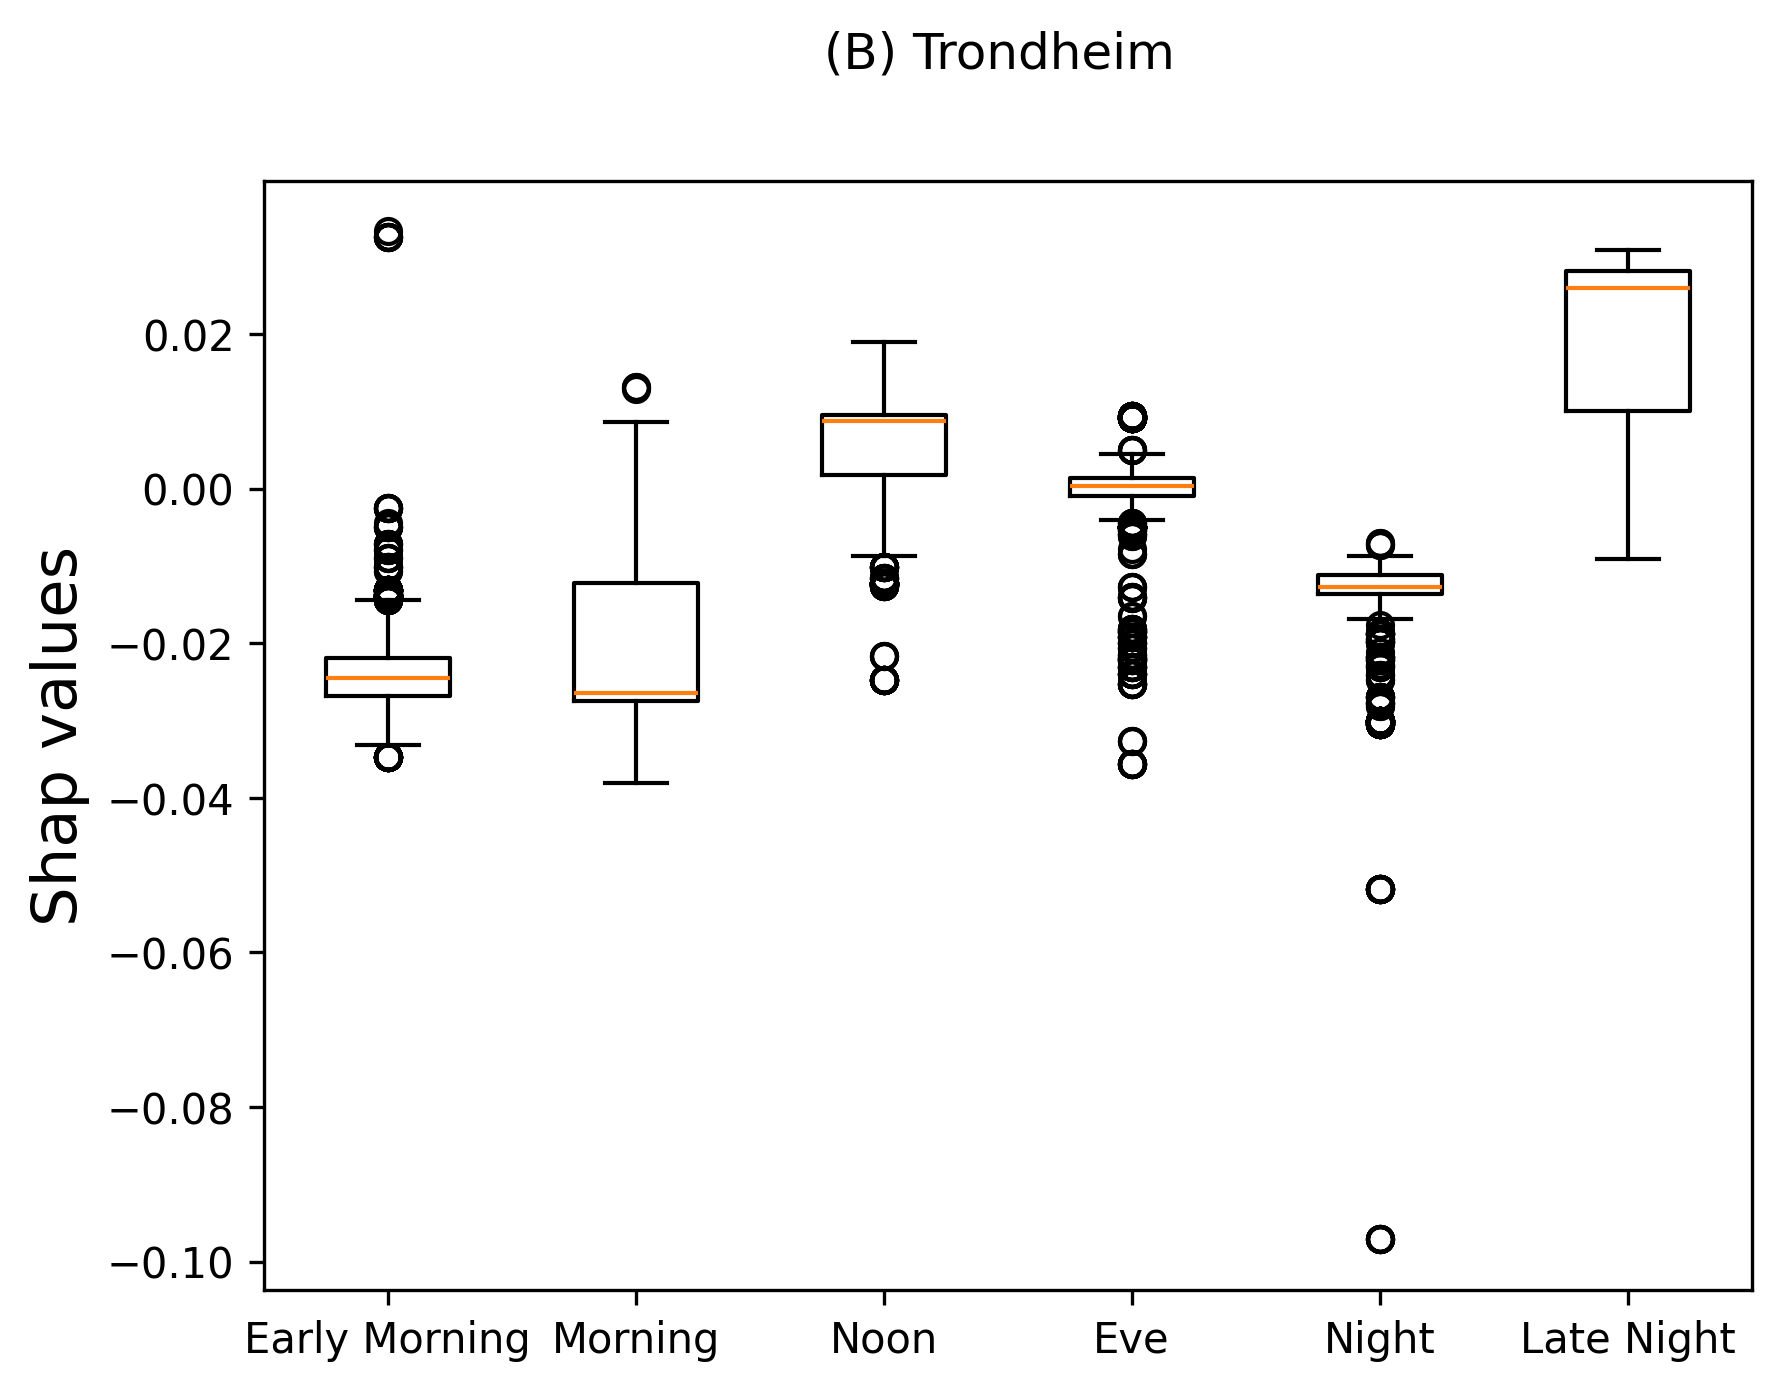

In [63]:
#split Time_in_h shap values based on Time_in_h values

timeinH_values = shap_values[:,"AdmtimeGrp"].values
timeinH_data = shap_values[:,"AdmtimeGrp"].data
#timeinH_categories = list(set(timeinH_data))

timeinH_groups = []
for o in timeinH_categories:
    relevant_values = timeinH_values[timeinH_data == o]
    timeinH_groups.append(relevant_values)



labels = timeinH_categories
#labels= [timeinH_labels[u] for u in timeinH_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))

plt.boxplot(timeinH_groups,labels=labels)

plt.ylabel('Shap values',size=15)
#plt.xlabel('AdmtimeGrp',size=15)
plt.title('(B) Trondheim ', y=1.08)

Text(0.5, 1.08, '(B) Trondheim ')

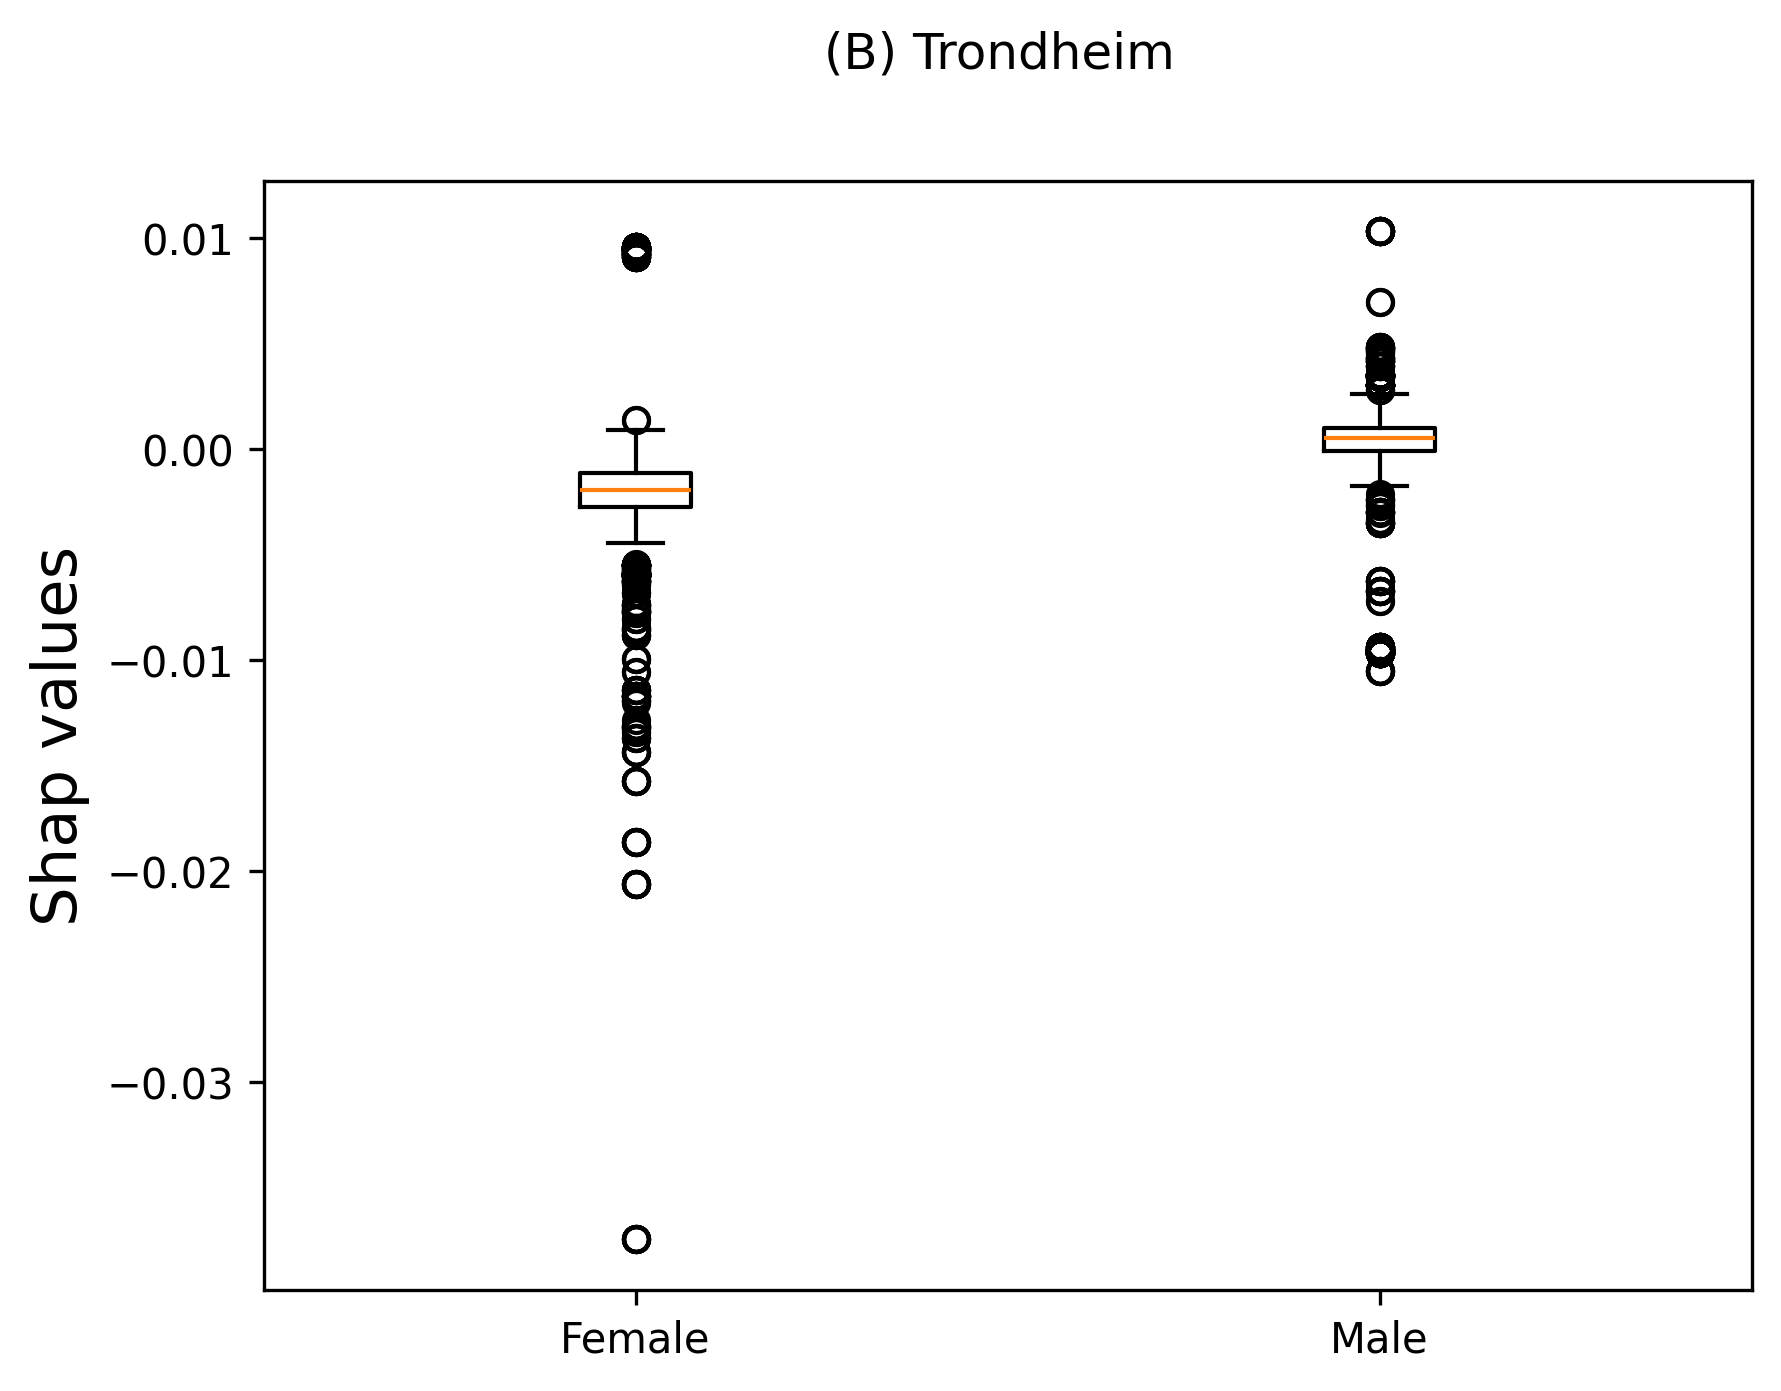

In [64]:
#split Time_in_h shap values based on AgeGroup category

Kjonn_values = shap_values[:,"Kjonn"].values
Kjonn_data = shap_values[:,"Kjonn"].data
Kjonn_categories = list(set(Kjonn_data))

Kjonn_groups = []
for o in Kjonn_categories:
    relevant_values = Kjonn_values[Kjonn_data == o]
    Kjonn_groups.append(relevant_values)

#replace categories with labels
Kjonn_labels = {'Kvinne':'Female',
                'Mann':'Male',
                'missing':'Missing'






              }

labels = Kjonn_categories
labels= [Kjonn_labels[u] for u in Kjonn_categories]

#plot boxplot
#plt.figure(figsize=(20, 10))

plt.boxplot(Kjonn_groups,labels=labels)

plt.ylabel('Shap values',size=15)
#plt.xlabel('Sex',size=15)
plt.title('(B) Trondheim ', y=1.08)